# AISE4010 - Group 16
*   Short-Term Load Forecasting with Smart Grid Real-Time Data
*   Dataset: smart_grid_dataset.csv
*   Owen O'Donnell - 251292980
*   Ryan Gibson - 251290212
*   Caden Curran - 251287592







# Section 1. Imports & Global Config

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LSTM, GRU, Conv1D, BatchNormalization,
    ReLU, GlobalAveragePooling1D, MaxPooling1D, SimpleRNN
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization

import itertools
import time
import os

# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

plt.style.use("seaborn-v0_8")

#creating path for comparisons
RESULTS_DIR = "results/comparisons"
os.makedirs(RESULTS_DIR, exist_ok=True)

#creating path for figures
FIG_DIR = "results/figures"
os.makedirs(FIG_DIR, exist_ok=True)

#creating path for model summaries
SUM_DIR = "results/summaries"
os.makedirs(SUM_DIR, exist_ok=True)

#function to save model summary
def save_model_summary(model, filename):
    path = os.path.join(FIG_DIR, filename)
    with open(path, "w") as f:
        model.summary(print_fn=lambda line: f.write(line + "\n"))


# Section 2. Load & Preview Dataset

In [2]:
from google.colab import files

uploaded = files.upload()  # Upload smart_grid_dataset.csv

csv_name = list(uploaded.keys())[0]
df = pd.read_csv(csv_name)
print(df.head())
print(df.columns)


Saving smart_grid_dataset.csv to smart_grid_dataset.csv
             Timestamp  Voltage (V)  Current (A)  Power Consumption (kW)  \
0  2024-01-01 00:00:00   232.483571     5.124673                1.191402   
1  2024-01-01 00:15:00   229.308678    22.213519                5.093753   
2  2024-01-01 00:30:00   233.238443    46.132217               10.759806   
3  2024-01-01 00:45:00   237.615149    47.648972               11.322118   
4  2024-01-01 01:00:00   228.829233     7.410166                1.695663   

   Reactive Power (kVAR)  Power Factor  Solar Power (kW)  Wind Power (kW)  \
0               0.399029      0.907766         46.614845        26.399566   
1               1.248030      0.831813          6.907170        18.555011   
2               2.790464      0.999005         15.477640        12.905025   
3               1.956965      0.896462         35.746398        28.937129   
4               0.624718      0.870681         27.555038        14.184648   

   Grid Supply (kW)  Vol

# Section 3. Timestamp parsing & Cleaning

In [3]:
# Parse timestamp and sort
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df = df.set_index('Timestamp')

# Optionally resample to a regular 15-min grid
df = df.resample('15T').mean()

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Drop any remaining missing rows just in case
df = df.dropna()

print(df.head())
print(df.isna().sum())


                     Voltage (V)  Current (A)  Power Consumption (kW)  \
Timestamp                                                               
2024-01-01 00:00:00   232.483571     5.124673                1.191402   
2024-01-01 00:15:00   229.308678    22.213519                5.093753   
2024-01-01 00:30:00   233.238443    46.132217               10.759806   
2024-01-01 00:45:00   237.615149    47.648972               11.322118   
2024-01-01 01:00:00   228.829233     7.410166                1.695663   

                     Reactive Power (kVAR)  Power Factor  Solar Power (kW)  \
Timestamp                                                                    
2024-01-01 00:00:00               0.399029      0.907766         46.614845   
2024-01-01 00:15:00               1.248030      0.831813          6.907170   
2024-01-01 00:30:00               2.790464      0.999005         15.477640   
2024-01-01 00:45:00               1.956965      0.896462         35.746398   
2024-01-01 01:00:00 

/tmp/ipython-input-2608700131.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df = df.resample('15T').mean()


# Section 4. Exploratory Data Analysis (EDA)

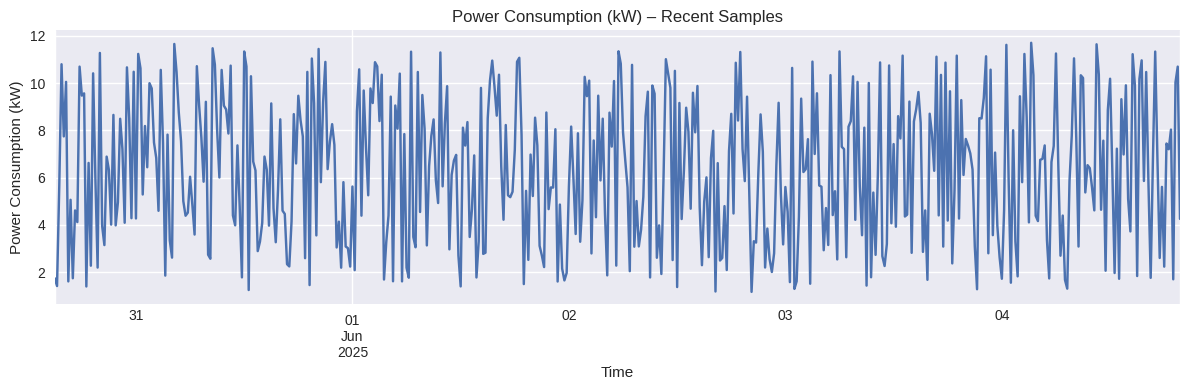

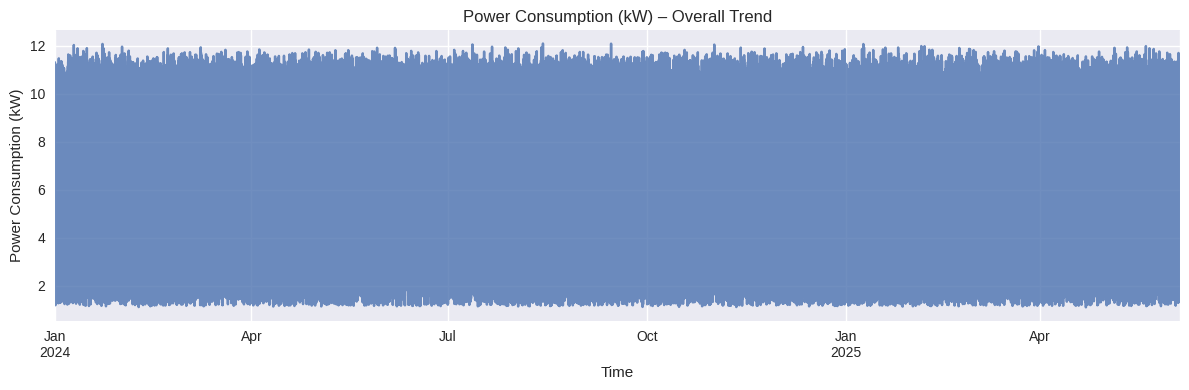

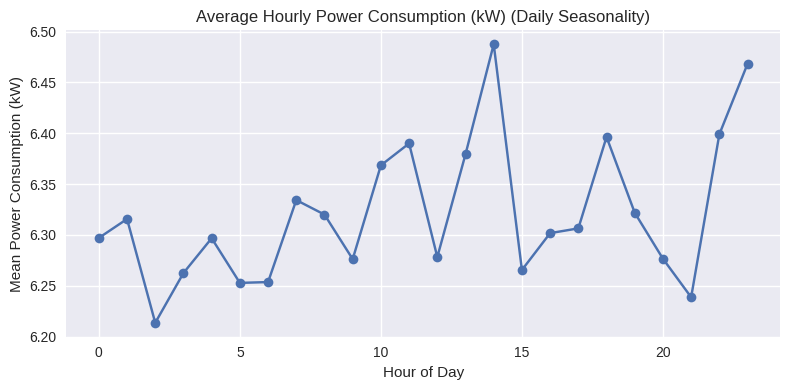

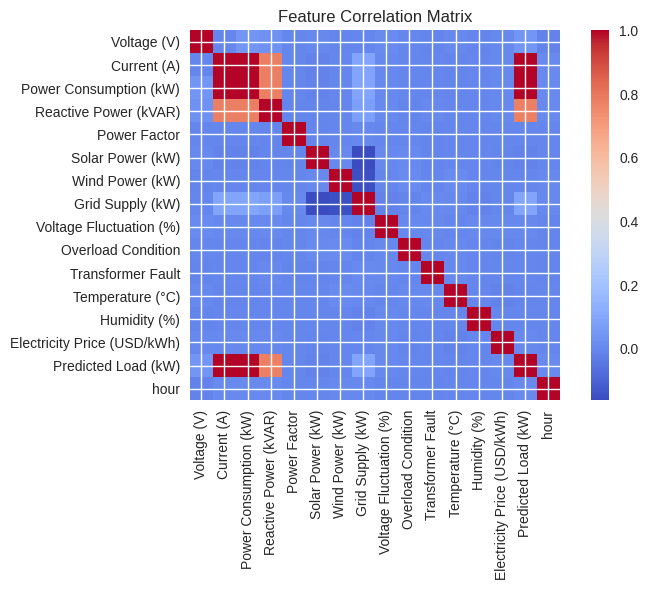

In [4]:
target_col = 'Power Consumption (kW)'   # Change if you want to forecast another variable

# 4A: Recent samples of target
plt.figure(figsize=(12,4))
df[target_col].tail(500).plot()
plt.title(f"{target_col} – Recent Samples")
plt.ylabel(target_col)
plt.xlabel("Time")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"{target_col}_recent_samples.png"), dpi=150)
plt.show()

# 4B: Full trend
plt.figure(figsize=(12,4))
df[target_col].plot(alpha=0.8)
plt.title(f"{target_col} – Overall Trend")
plt.ylabel(target_col)
plt.xlabel("Time")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"{target_col}_overall_trend.png"), dpi=150)
plt.show()

# 4C: Daily seasonality
df['hour'] = df.index.hour
hourly_avg = df.groupby('hour')[target_col].mean()

plt.figure(figsize=(8,4))
hourly_avg.plot(marker='o')
plt.title(f"Average Hourly {target_col} (Daily Seasonality)")
plt.ylabel(f"Mean {target_col}")
plt.xlabel("Hour of Day")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, f"{target_col}_daily_seasonality.png"), dpi=150)
plt.show()

# 4D: Correlation heatmap between main numeric features
num_cols = df.select_dtypes('number').columns
corr = df[num_cols].corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "feature_correlation_matrix.png"), dpi=150)
plt.show()

# Remove helper column so it doesn't leak into later modeling unintentionally
df = df.drop(columns=['hour'])

# Section 5. Feature Engineering

In [5]:

# Choose base features
feature_cols = [
    'Voltage (V)',
    'Current (A)',
    'Power Consumption (kW)',
    'Reactive Power (kVAR)',
    'Power Factor',
    'Solar Power (kW)'
]

# Start feature dataframe
df_feat = df[feature_cols].copy()

# Calendar-based features
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['is_weekend'] = (df_feat['dayofweek'] >= 5).astype(int)

# Smooth Target to 1-hour average
df_feat['target_smooth'] = df_feat['Power Consumption (kW)'].rolling(4).mean()

# Remove rows with NA from rolling window
df_feat = df_feat.dropna()

# Set this as our forecast target
target_col = 'target_smooth'

print(df_feat.head())
print("Final feature count:", df_feat.shape[1])

                     Voltage (V)  Current (A)  Power Consumption (kW)  \
Timestamp                                                               
2024-01-01 00:45:00   237.615149    47.648972               11.322118   
2024-01-01 01:00:00   228.829233     7.410166                1.695663   
2024-01-01 01:15:00   228.829315    10.554009                2.415067   
2024-01-01 01:30:00   237.896064     5.219166                1.241619   
2024-01-01 01:45:00   233.837174    44.090317               10.309955   

                     Reactive Power (kVAR)  Power Factor  Solar Power (kW)  \
Timestamp                                                                    
2024-01-01 00:45:00               1.956965      0.896462         35.746398   
2024-01-01 01:00:00               0.624718      0.870681         27.555038   
2024-01-01 01:15:00               0.935853      0.970003         46.029339   
2024-01-01 01:30:00               0.368005      0.962855         21.536427   
2024-01-01 01:45:00 

## Section 5.1 Scaling, Train/Validation/Test Split, and Window Creation

In [6]:

# Scale data together
scaler = MinMaxScaler()
scaled_all = scaler.fit_transform(df_feat)
scaled_df = pd.DataFrame(scaled_all, index=df_feat.index, columns=df_feat.columns)

# Split into X and y
X_all = scaled_df.drop(columns=[target_col]).values
y_all = scaled_df[target_col].values.reshape(-1, 1)

# Chronological split
n = len(X_all)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X_train = X_all[:train_end]
X_val   = X_all[train_end:val_end]
X_test  = X_all[val_end:]

y_train = y_all[:train_end]
y_val   = y_all[train_end:val_end]
y_test  = y_all[val_end:]

# 8-step window (2 hours) works best with smoothed load
WINDOW = 8

def make_windows(X, y, window):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

# Create sliding windows for deep-learning models
X_train_dl, y_train_dl = make_windows(X_train, y_train, WINDOW)
X_val_dl,   y_val_dl   = make_windows(X_val,   y_val,   WINDOW)
X_test_dl,  y_test_dl  = make_windows(X_test,  y_test,  WINDOW)

print("Training window shape:", X_train_dl.shape)
print("Validation window shape:", X_val_dl.shape)
print("Testing window shape:", X_test_dl.shape)


Training window shape: (34989, 8, 9)
Validation window shape: (7492, 8, 9)
Testing window shape: (7492, 8, 9)


In [7]:
def inverse_and_metrics(y_true_scaled, y_pred_scaled, y_scaler, label="Model"):
    y_true = y_scaler.inverse_transform(y_true_scaled)
    y_pred = y_scaler.inverse_transform(y_pred_scaled)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

    print(f"{label} – RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    return rmse, mae, mape, y_true.flatten(), y_pred.flatten()


## Section 5.2 Anomaly Detection

Running anomaly detection on scaled_df...
Isolation Forest anomalies detected: 750
Epoch 1/40


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0710
Epoch 2/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012
Epoch 3/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2894e-04
Epoch 4/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4801e-05
Epoch 5/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2299e-05
Epoch 6/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.5164e-05
Epoch 7/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0234e-05
Epoch 8/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.8232e-05
Epoch 9/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.0941e-05
Epoch 10/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1147e-05
Epoch 11/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2625e-05
Epoch 12/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.4655e-05
Epoch 13/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.6488e-05
Epoch 14/40
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.9924e-05
Epoch 15/40
391/391 

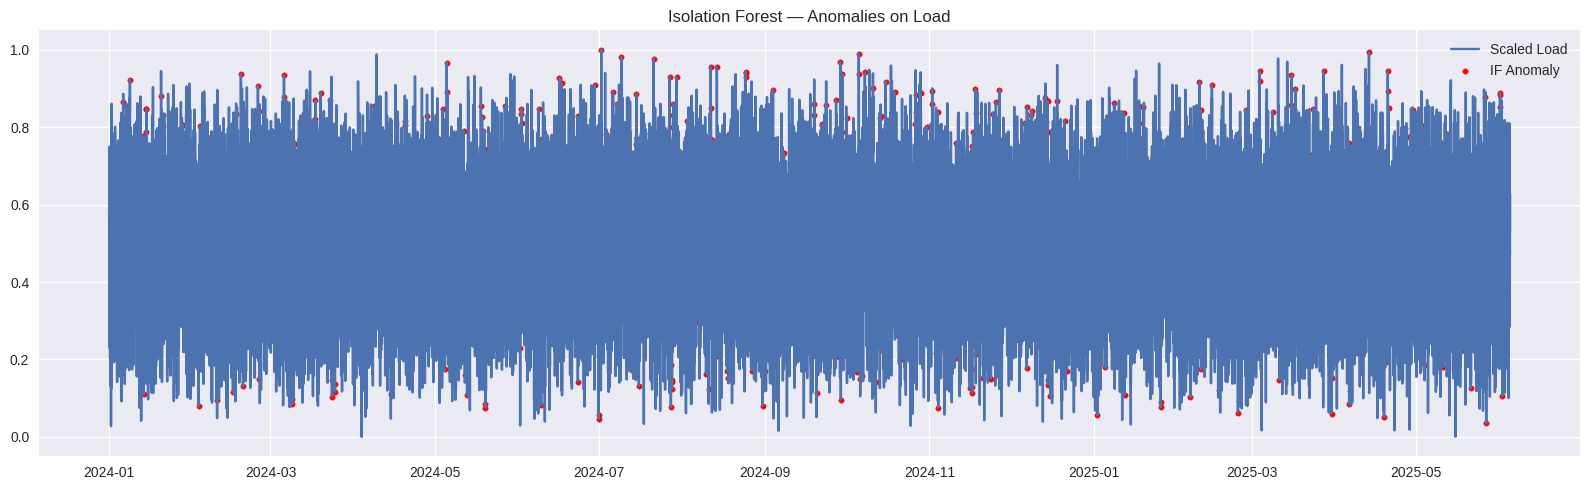

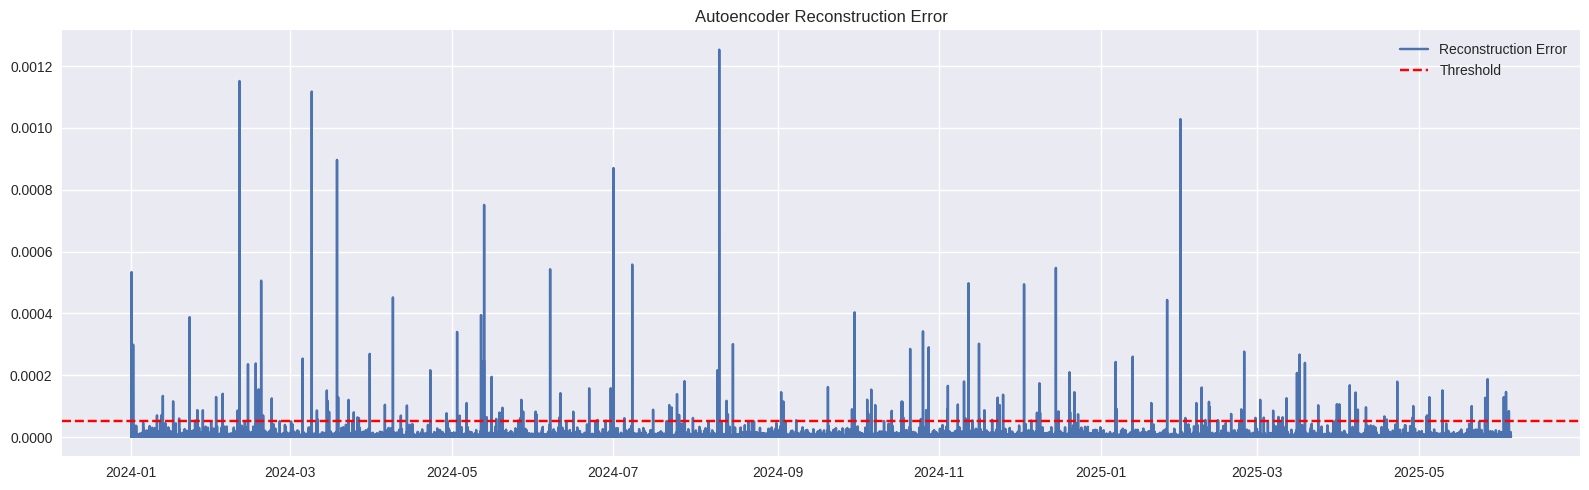

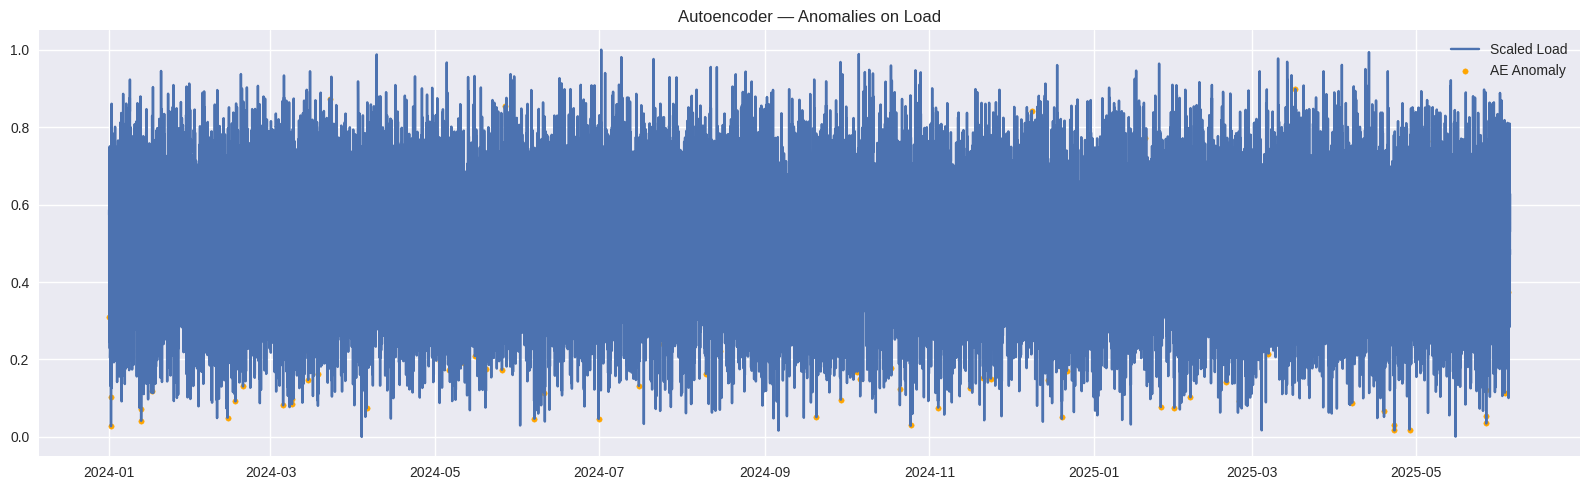

Anomaly detection completed.


In [8]:
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

print("Running anomaly detection on scaled_df...")

# Use the fully scaled dataframe (features + target)
scaled_data = scaled_df.values.astype("float32")
timestamps = scaled_df.index  # timestamps preserved after parsing/resampling

# Isolation Forest
iso = IsolationForest(
    n_estimators=300,
    contamination=0.015,    # ~1.5% anomaly rate – works well for smart grid load
    random_state=42
)

iso_labels = iso.fit_predict(scaled_data)
scaled_df["iso_anomaly"] = (iso_labels == -1).astype(int)
print("Isolation Forest anomalies detected:", scaled_df["iso_anomaly"].sum())


# Autoencoder anomaly detection
auto = Sequential([
    Dense(64, activation='relu', input_shape=(scaled_data.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(scaled_data.shape[1], activation='linear')
])

auto.compile(optimizer=Adam(0.001), loss='mse')

history = auto.fit(
    scaled_data, scaled_data,
    epochs=40,
    batch_size=128,
    shuffle=True,
    verbose=1
)

# Reconstruction errors
reconstructed = auto.predict(scaled_data)
recon_errors = np.mean(np.square(scaled_data - reconstructed), axis=1)
scaled_df["ae_error"] = recon_errors

# 3-sigma threshold
ae_threshold = recon_errors.mean() + 3 * recon_errors.std()
scaled_df["ae_anomaly"] = (scaled_df["ae_error"] > ae_threshold).astype(int)
print("Autoencoder anomalies detected:", scaled_df["ae_anomaly"].sum())


# 1 — Isolation Forest Plot
plt.figure(figsize=(16,5))
plt.plot(timestamps, scaled_df[target_col], label="Scaled Load")
plt.scatter(
    timestamps[scaled_df["iso_anomaly"] == 1],
    scaled_df[target_col][scaled_df["iso_anomaly"] == 1],
    color='red', s=15, label="IF Anomaly"
)
plt.title("Isolation Forest — Anomalies on Load")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "isolation_forest_anomalies.png"), dpi=150)
plt.show()

# 2 — Autoencoder reconstruction error plot
plt.figure(figsize=(16,5))
plt.plot(timestamps, scaled_df["ae_error"], label="Reconstruction Error")
plt.axhline(ae_threshold, color='red', linestyle='--', label="Threshold")
plt.title("Autoencoder Reconstruction Error")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "autoencoder_reconstruction_error.png"), dpi=150)
plt.show()

# 3 — Autoencoder anomalies on target plot
plt.figure(figsize=(16,5))
plt.plot(timestamps, scaled_df[target_col], label="Scaled Load")
plt.scatter(
    timestamps[scaled_df["ae_anomaly"] == 1],
    scaled_df[target_col][scaled_df["ae_anomaly"] == 1],
    color='orange', s=15, label="AE Anomaly"
)
plt.title("Autoencoder — Anomalies on Load")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "autoencoder_anomalies.png"), dpi=150)
plt.show()

print("Anomaly detection completed.")

# Section 6. Naive Model (Predict Previous Value)

In [9]:

# naive: predict previous value
y_naive = y_test
mse_naive = mean_squared_error(y_test, y_naive)
rmse_naive = np.sqrt(mse_naive)
mae_naive  = mean_absolute_error(y_test, y_naive)
mape_naive = np.mean(np.abs((y_test - y_naive) / (y_test + 1e-8))) * 100
r2_naive = r2_score(y_test, y_naive)
print("Naive RMSE:", rmse_naive)
print("Naive MAE :", mae_naive)
print("Naive MAPE:", mape_naive)
print("Naive R2  :", r2_naive)


Naive RMSE: 0.0
Naive MAE : 0.0
Naive MAPE: 0.0
Naive R2  : 1.0


# Section 7. ARIMA and SARIMA

## 7.1 Obtaining p,d,q values

Time range: 2024-01-01 00:00:00 to 2025-06-04 19:45:00
Number of points: 50000
Train length: 40001 Test length: 10000

ADF Test for y_train (original):
  Test statistic: -98.7831
  p-value       : 0.0000
  => Reject H0 (unit root). Series is likely STATIONARY.

ADF Test for y_train (1st difference):
  Test statistic: -47.2130
  p-value       : 0.0000
  => Reject H0 (unit root). Series is likely STATIONARY.


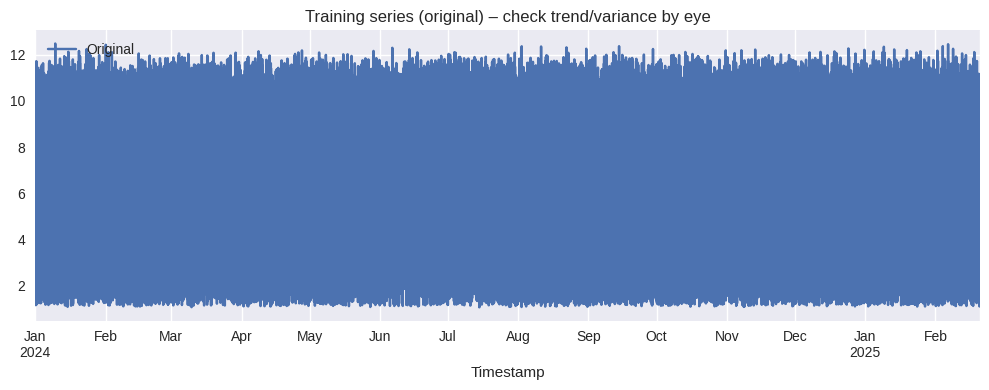

In [10]:
# EXTRACT SERIES + STATIONARITY CHECK / DIFFERENCING
from statsmodels.tsa.stattools import adfuller

# Extract univariate series (Predicted Load) with 15-min freq
y = df["Predicted Load (kW)"].sort_index()

y = y.asfreq("15min")   # ensure a regular frequency

print("Time range:", y.index.min(), "to", y.index.max())
print("Number of points:", len(y))

# Train / Test split aligned with your deep learning splits
train_end = y.index[int(len(y) * 0.8)]   # 80% train, 20% test for ARIMA
y_train = y[:train_end]
y_test  = y[train_end:]

print("Train length:", len(y_train), "Test length:", len(y_test))

# ADF test for stationarity
def adf_test(series, name="series"):
    result = adfuller(series.dropna())
    stat, pvalue = result[0], result[1]
    print(f"\nADF Test for {name}:")
    print(f"  Test statistic: {stat:.4f}")
    print(f"  p-value       : {pvalue:.4f}")
    if pvalue < 0.05:
        print("  => Reject H0 (unit root). Series is likely STATIONARY.")
    else:
        print("  => Fail to reject H0. Series is likely NON-STATIONARY.")

adf_test(y_train, "y_train (original)")

# 4) If non-stationary, apply regular differencing
use_diff = True   # set False if ADF already shows stationarity

if use_diff:
    y_train_diff = y_train.diff().dropna()
    adf_test(y_train_diff, "y_train (1st difference)")
else:
    y_train_diff = y_train.copy()

# Quick plot to visualize differencing effect
plt.figure(figsize=(10, 4))
y_train.plot(label="Original")
if use_diff:
    plt.title("Training series (original) – check trend/variance by eye")
else:
    plt.title("Training series (no differencing applied)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "training_series_diff.png"), dpi=150)
plt.show()


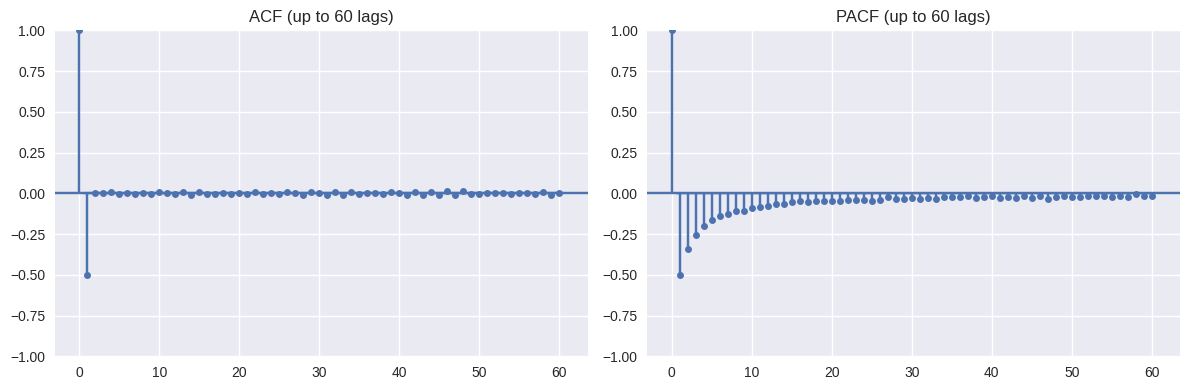


Interpretation hints (rule of thumb):
- If ACF tails off, PACF cuts off at lag p  -> AR(p)
- If ACF cuts off at lag q, PACF tails off -> MA(q)
- If both tail off                        -> ARMA / ARIMA

For seasonality (SARIMA):
- Look for spikes at multiples of the seasonal period s
  For 15-min data with daily seasonality, s = 96 (96 * 15min = 24h).
  For weekly seasonality, s = 96 * 7 = 672.
You will choose (p,d,q) and (P,D,Q,s) in the next cell.



In [11]:
# ACF/PACF FOR ARIMA/SARIMA ORDER SELECTION
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Use the differenced series if we decided to difference
series_for_plots = y_train_diff if use_diff else y_train

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(series_for_plots, lags=60, ax=axes[0])
axes[0].set_title("ACF (up to 60 lags)")
plot_pacf(series_for_plots, lags=60, ax=axes[1])
axes[1].set_title("PACF (up to 60 lags)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "acf_pacf.png"), dpi=150)
plt.show()

print("""
Interpretation hints (rule of thumb):
- If ACF tails off, PACF cuts off at lag p  -> AR(p)
- If ACF cuts off at lag q, PACF tails off -> MA(q)
- If both tail off                        -> ARMA / ARIMA

For seasonality (SARIMA):
- Look for spikes at multiples of the seasonal period s
  For 15-min data with daily seasonality, s = 96 (96 * 15min = 24h).
  For weekly seasonality, s = 96 * 7 = 672.
You will choose (p,d,q) and (P,D,Q,s) in the next cell.
""")


## 7.2 ARIMA Model

In [12]:
# FIT ARIMA AND SARIMA MODELS
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Non-seasonal ARIMA(p, d, q)
d = 1            # d = 0,1
p, q = 2, 1      # adjusted after looking at ACF/PACF ( p = 0,1,2; q = 0,1)

order = (p, d, q)

print("Using ARIMA order:", order)

start = time.time() #start training time

# Fit ARIMA
arima_model = SARIMAX(
    y_train,
    order=order,
    seasonal_order=(0, 0, 0, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

arima_train_time = time.time() - start
print(f"\nARIMA training time: {arima_train_time:.2f} seconds")

print("\nARIMA model summary:")
print(arima_model.summary().tables[1])

Using ARIMA order: (2, 1, 1)

ARIMA training time: 15.65 seconds

ARIMA model summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0099      0.005     -2.003      0.045      -0.020      -0.000
ar.L2         -0.0008      0.005     -0.174      0.862      -0.010       0.009
ma.L1         -1.0000      0.000  -9089.001      0.000      -1.000      -1.000
sigma2         8.9806      0.099     90.464      0.000       8.786       9.175



ARIMA RMSE: 2.9975
ARIMA MAE : 2.5946
ARIMA MAPE: 67.31%
ARIMA R2  : -0.0001

ARIMA testing time: 0.39 seconds


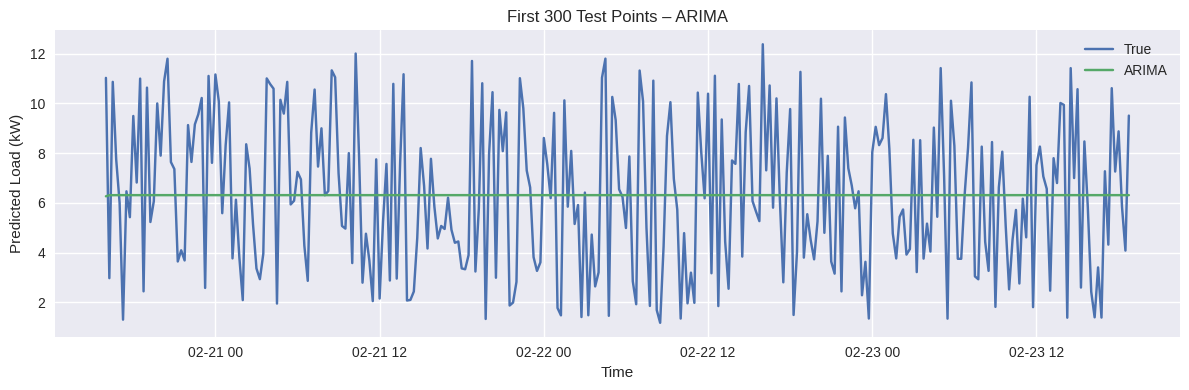

In [13]:
# TEST FORECASTS + METRICS (ARIMA / SARIMA)

start = time.time() #start time

# ARIMA forecasts
arima_forecast = arima_model.get_forecast(steps=len(y_test))
arima_pred = arima_forecast.predicted_mean
arima_pred.index = y_test.index  # align indices

arima_test_time = time.time() - start

#Metrics
mse_arima = mean_squared_error(y_test, arima_pred)
rmse_arima = np.sqrt(mse_arima)
mae_arima  = mean_absolute_error(y_test, arima_pred)
mape_arima = np.mean(np.abs((y_test - arima_pred) / (y_test + 1e-8))) * 100
r2_arima = r2_score(y_test, arima_pred)

print(f"\nARIMA RMSE: {rmse_arima:.4f}")
print(f"ARIMA MAE : {mae_arima:.4f}")
print(f"ARIMA MAPE: {mape_arima:.2f}%")
print(f"ARIMA R2  : {r2_arima:.4f}")
print(f"\nARIMA testing time: {arima_test_time:.2f} seconds")

# Plot comparison (first N points for clarity)
N = 300  # adjust for visibility
plt.figure(figsize=(12, 4))
plt.plot(y_test.iloc[:N], label="True")
plt.plot(arima_pred.iloc[:N], label="ARIMA")
plt.title(f"First {N} Test Points – ARIMA")
plt.xlabel("Time")
plt.ylabel("Predicted Load (kW)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "arima_model.png"), dpi=150)
plt.show()


## 7.3 SARIMA Model

/tmp/ipython-input-1261068270.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_hourly = y_15min.resample("H").mean()


Hourly series length: 12500
Hourly range: 2024-01-01 00:00:00 → 2025-06-04 19:00:00
Train len: 10000 Test len: 2500
Using SARIMA order: (1, 0, 1) seasonal_order: (1, 1, 1, 24)

SARIMA training time: 90.58 seconds
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6294      0.708      0.890      0.374      -0.757       2.016
ma.L1         -0.6237      0.712     -0.877      0.381      -2.018       0.771
ar.S.L24      -0.0029      0.002     -1.744      0.081      -0.006       0.000
ma.S.L24      -0.9956      0.002   -430.569      0.000      -1.000      -0.991
sigma2         2.2317      0.034     65.174      0.000       2.165       2.299

SARIMA (hourly) RMSE: 1.4834
SARIMA (hourly) MAE : 1.1901
SARIMA (hourly) MAPE: 21.28%
SARIMA (hourly) R2  : -0.0059

SARIMA (hourly) testing time: 0.23 seconds


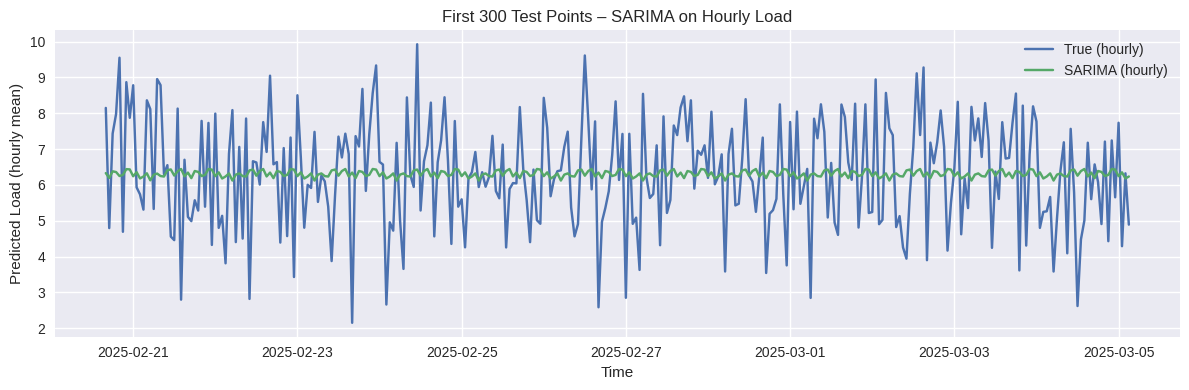

In [14]:

# Downsample to hourly mean for SARIMA
y_15min = df["Predicted Load (kW)"].sort_index()
y_hourly = y_15min.resample("H").mean()

print("Hourly series length:", len(y_hourly))
print("Hourly range:", y_hourly.index.min(), "→", y_hourly.index.max())

# Train / test split (80/20)
split_idx = int(len(y_hourly) * 0.8)
y_train = y_hourly.iloc[:split_idx]
y_test  = y_hourly.iloc[split_idx:]

print("Train len:", len(y_train), "Test len:", len(y_test))

# SARIMA with small orders and daily seasonality (s = 24 hours)
order = (1, 0, 1)          # keep small for speed
seasonal_order = (1, 1, 1, 24)
print("Using SARIMA order:", order, "seasonal_order:", seasonal_order)


start = time.time() #start training time

model = SARIMAX(
    y_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarima_train_time = time.time() - start
print(f"\nSARIMA training time: {sarima_train_time:.2f} seconds")

print(model.summary().tables[1])


start = time.time() #start training time

# Forecast over test horizon
forecast = model.get_forecast(steps=len(y_test))
y_pred = forecast.predicted_mean
y_pred.index = y_test.index

sarima_test_time = time.time() - start

# Metrics
mse_sarima = mean_squared_error(y_test, y_pred)
rmse_sarima = np.sqrt(mse_sarima)
mae_sarima  = mean_absolute_error(y_test, y_pred)
mape_sarima = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100
r2_sarima = r2_score(y_test, y_pred)

print(f"\nSARIMA (hourly) RMSE: {rmse_sarima:.4f}")
print(f"SARIMA (hourly) MAE : {mae_sarima:.4f}")
print(f"SARIMA (hourly) MAPE: {mape_sarima:.2f}%")
print(f"SARIMA (hourly) R2  : {r2_sarima:.4f}")
print(f"\nSARIMA (hourly) testing time: {sarima_test_time:.2f} seconds")

# Plot first N points
N = min(300, len(y_test))
plt.figure(figsize=(12, 4))
plt.plot(y_test.iloc[:N], label="True (hourly)")
plt.plot(y_pred.iloc[:N], label="SARIMA (hourly)")
plt.title(f"First {N} Test Points – SARIMA on Hourly Load")
plt.xlabel("Time")
plt.ylabel("Predicted Load (hourly mean)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "sarima_model.png"), dpi=150)
plt.show()


# Section 8. Model Definitions (LSTM, GRU, TCN, Transformer, RNN)

In [15]:
n_features = X_train_dl.shape[-1]

#define basis for lstm model
def build_lstm_improved(window, n_features, units1=128, units2=64,
                        dropout_rate=0.1, lr=1e-3):
    model = Sequential(name="LSTM")
    model.add(LSTM(units1, return_sequences=True,
                   input_shape=(window, n_features)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

#define basis for gru model
def build_gru(window, n_features, units1=64, units2=32, dropout=0.2, lr=1e-3):
    model = Sequential([
        GRU(units1, return_sequences=True, input_shape=(window, n_features)),
        Dropout(dropout),
        GRU(units2),
        Dropout(dropout),
        Dense(1)
    ], name="GRU") # Moved name to the end
    model.compile(optimizer='adam', loss='mse')
    return model

#define basis for tcn model
def build_tcn(window, n_features, filters=32, kernel_size=3, lr=1e-3):
    inp = Input(shape=(window, n_features))

    x = Conv1D(filters, kernel_size, dilation_rate=1, padding='causal')(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters, kernel_size, dilation_rate=2, padding='causal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters, kernel_size, dilation_rate=4, padding='causal')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out, name="TCN")


    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

#define basis for transformer model
def build_transformer(window, n_features, d_model=64, num_heads=4,
                      ff_dim=128, dropout_rate=0.1, lr=1e-3):

    inp = Input(shape=(window, n_features))

    x = Dense(d_model)(inp)

    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model // num_heads
    )(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)  # residual

    ff_output = Dense(ff_dim, activation="relu")(x)
    ff_output = Dropout(dropout_rate)(ff_output)

    ff_output = Dense(d_model)(ff_output) # Project back to d_model
    ff_output = Dropout(dropout_rate)(ff_output)

    x = LayerNormalization(epsilon=1e-6)(x + ff_output)  # residual

    x = GlobalAveragePooling1D()(x)

    x = Dense(32, activation="relu")(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out, name="Transformer")
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse")
    return model

#define basis for rnn model
def build_rnn(window, n_features,
              units1=64, units2=32,
              dropout_rate=0.2, lr=1e-3):
    model = Sequential([
        tf.keras.layers.SimpleRNN(
            units1, return_sequences=True,
            input_shape=(window, n_features)
        ),
        Dropout(dropout_rate),
        tf.keras.layers.SimpleRNN(units2),
        Dropout(dropout_rate),
        Dense(1)
     ], name="RNN") # Moved name to the end
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse")
    return model


#build all models
lstm_model = build_lstm_improved(WINDOW, n_features)
gru_model  = build_gru(WINDOW, n_features)
tcn_model  = build_tcn(WINDOW, n_features)
transformer_model = build_transformer(WINDOW, n_features)
rnn_model = build_rnn(WINDOW, n_features)

#summarize each for clear layout of each initial network
lstm_model.summary()
gru_model.summary()
tcn_model.summary()
transformer_model.summary()
rnn_model.summary()

save_model_summary(lstm_model, "lstm_summary.txt")
save_model_summary(gru_model, "gru_summary.txt")
save_model_summary(tcn_model, "tcn_summary.txt")
save_model_summary(transformer_model, "transformer_summary.txt")
save_model_summary(rnn_model, "rnn_summary.txt")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,289 (485.50 KB)

 Trainable params: 124,289 (485.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8, 64)          │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,841 (93.13 KB)

 Trainable params: 23,841 (93.13 KB)

 Non-trainable params: 0 (0.00 B)

Model: "TCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 8, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 32)          │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,385 (32.75 KB)

 Non-trainable params: 192 (768.00 B)

Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 8, 9)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 8, 64)     │        640 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 64)     │     16,640 │ dense_11[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8, 64)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 64)     │          0 │ dense_11[0][0],   │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 8, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 8, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 128)    │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 8, 64)     │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 8, 64)     │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 64)     │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      2,080 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         33 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,225 (141.50 KB)

 Trainable params: 36,225 (141.50 KB)

 Non-trainable params: 0 (0.00 B)

Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8, 64)          │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,873 (30.75 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

# Section 9. LSTM Model

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - loss: 0.0156 - val_loss: 0.0079
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0075 - val_loss: 0.0083
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 37s 20ms/step - loss: 0.0065 - val_loss: 0.0073
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0063 - val_loss: 0.0067
Epoch 12

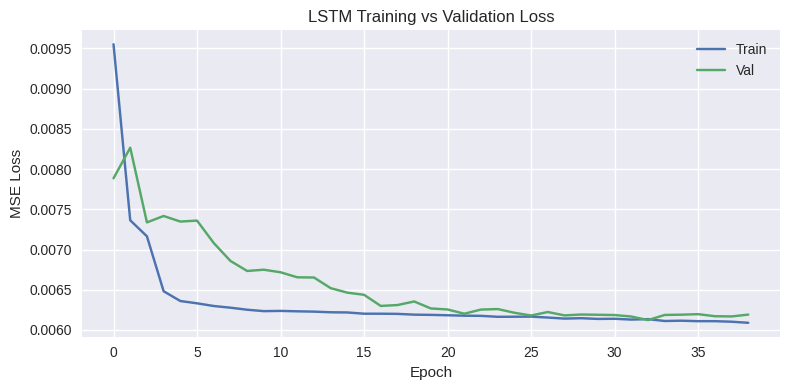

In [16]:
#LSTM TRAINING

early_lstm = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() #start training time

history_lstm = lstm_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_lstm],
    verbose=1
)

lstm_train_time = time.time() - start
print(f"\nLSTM training time: {lstm_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Val')
plt.title('LSTM Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "lstm_base.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
LSTM RMSE: 0.7629738084375742
LSTM MAE : 0.6564597175035002
LSTM MAPE : 10.983990177971819
LSTM R2 SCORE: 0.732081502592674

LSTM testing time: 2.91 seconds



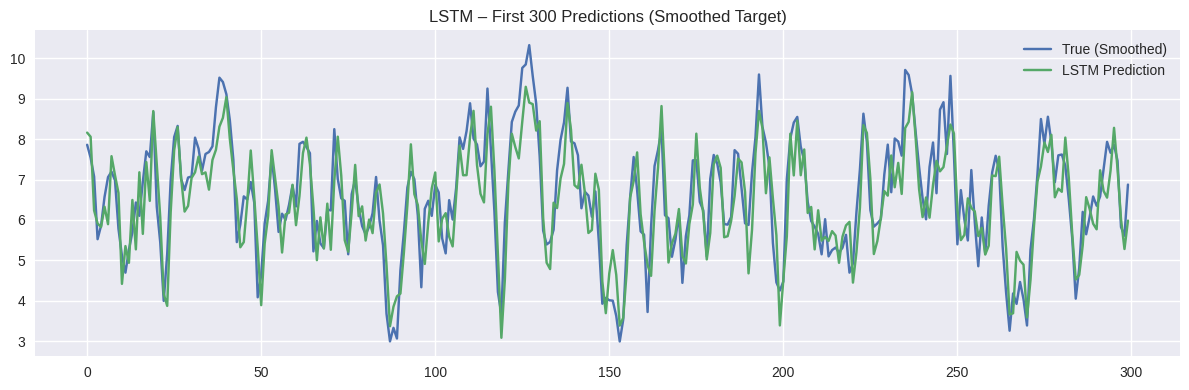

In [17]:
# LSTM EVALUATION

start = time.time() #start time

y_pred_lstm_scaled = lstm_model.predict(X_test_dl)

lstm_test_time = time.time() - start


# Find index of target column for inverse-transform
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Rebuild a full row with scaled y inserted so MinMaxScaler can invert properly.
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

# Build inverse-transformed results
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(x_last, y_pred_lstm_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i],           scaler, target_idx)

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Metrics
mse_lstm = mean_squared_error(y_true, y_pred)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm  = mean_absolute_error(y_true, y_pred)
mape_lstm = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_lstm = r2_score(y_true, y_pred)

print("LSTM RMSE:", rmse_lstm)
print("LSTM MAE :", mae_lstm)
print("LSTM MAPE :", mape_lstm)
print("LSTM R2 SCORE:", r2_lstm)
print(f"\nLSTM testing time: {lstm_test_time:.2f} seconds\n")

# Plot prediction window
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='LSTM Prediction')
plt.title("LSTM – First 300 Predictions (Smoothed Target)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "lstm_predict_base.png"), dpi=150)
plt.show()


# Section 10. GRU Model

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0187 - val_loss: 0.0085
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0091 - val_loss: 0.0077
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0067 - val_loss: 0.0065
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - loss: 0.0065 - val_loss: 0.0063
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 12

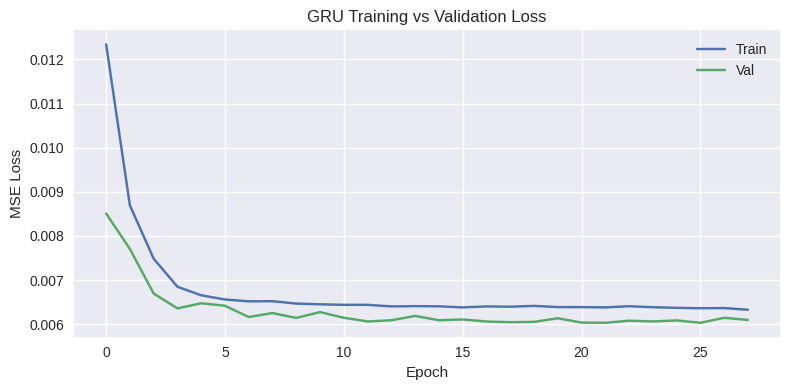

In [18]:
# GRU TRAINING
early_gru = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_gru = gru_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_gru],
    verbose=1
)

gru_train_time = time.time() - start
print(f"\nGRU training time: {gru_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Val')
plt.title('GRU Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "gru_base.png"), dpi=150)
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
GRU RMSE: 0.7571448171972558
GRU MAE : 0.6524598935033118
GRU MAPE : 11.017566871983409
GRU R2 SCORE: 0.7361595692725458

GRU testing time: 1.57 seconds



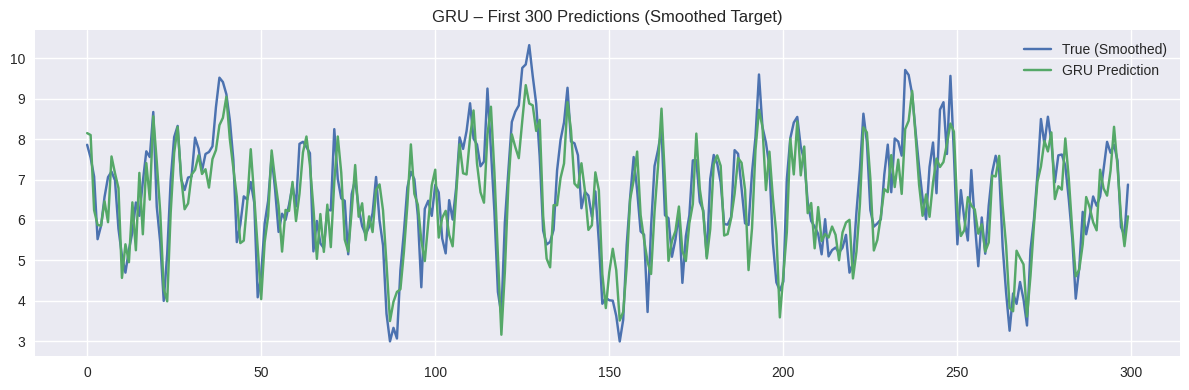

In [19]:
# GRU EVALUATION

start = time.time() # start time

y_pred_gru_scaled = gru_model.predict(X_test_dl)

gru_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)
def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Rebuild a full row with scaled y inserted so MinMaxScaler can invert properly.
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

y_pred_gru = []
y_true_gru = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(x_last, y_pred_gru_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i],          scaler, target_idx)

    y_pred_gru.append(pred_val)
    y_true_gru.append(true_val)

y_pred_gru = np.array(y_pred_gru)
y_true_gru = np.array(y_true_gru)

#Metrics
mse_gru = mean_squared_error(y_true_gru, y_pred_gru)
rmse_gru = np.sqrt(mse_gru)
mae_gru  = mean_absolute_error(y_true_gru, y_pred_gru)
mape_gru = np.mean(np.abs((y_true_gru - y_pred_gru) / y_true_gru)) * 100
r2_gru = r2_score(y_true_gru, y_pred_gru)

print("GRU RMSE:", rmse_gru)
print("GRU MAE :", mae_gru)
print("GRU MAPE :", mape_gru)
print("GRU R2 SCORE:", r2_gru)
print(f"\nGRU testing time: {gru_test_time:.2f} seconds\n")

# Plot prediction window
plt.figure(figsize=(12, 4))
plt.plot(y_true_gru[:300], label='True (Smoothed)')
plt.plot(y_pred_gru[:300], label='GRU Prediction')
plt.title("GRU – First 300 Predictions (Smoothed Target)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "gru_predict_base.png"), dpi=150)
plt.show()

# Section 11. TCN Model

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0292 - val_loss: 0.0070
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0073 - val_loss: 0.0069
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0068 - val_loss: 0.0067
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0066 - val_loss: 0.0063
Epoch 12/40
1094/1094 ━━━━━━━

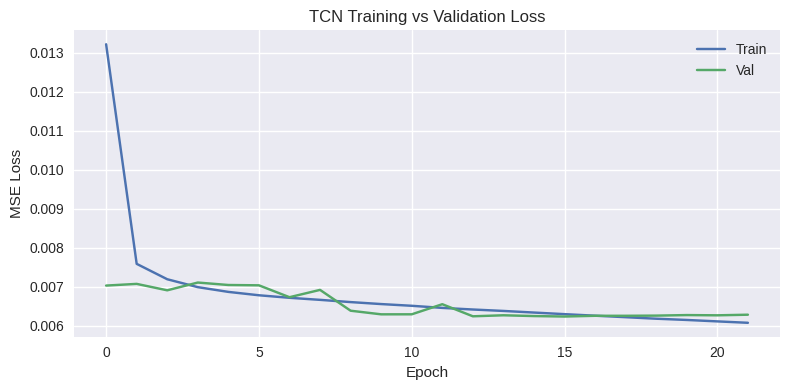

In [20]:
# TCN TRAINING
early_tcn = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_tcn = tcn_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_tcn],
    verbose=1
)

tcn_train_time = time.time() - start
print(f"\nTCN training time: {tcn_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_tcn.history['loss'], label='Train')
plt.plot(history_tcn.history['val_loss'], label='Val')
plt.title('TCN Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "tcn_base.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TCN RMSE: 0.7692965220142335
TCN MAE : 0.6598415535699721
TCN MAPE : 11.216786681859768
TCN R2 SCORE: 0.7276226579536613

TCN testing time: 0.84 seconds



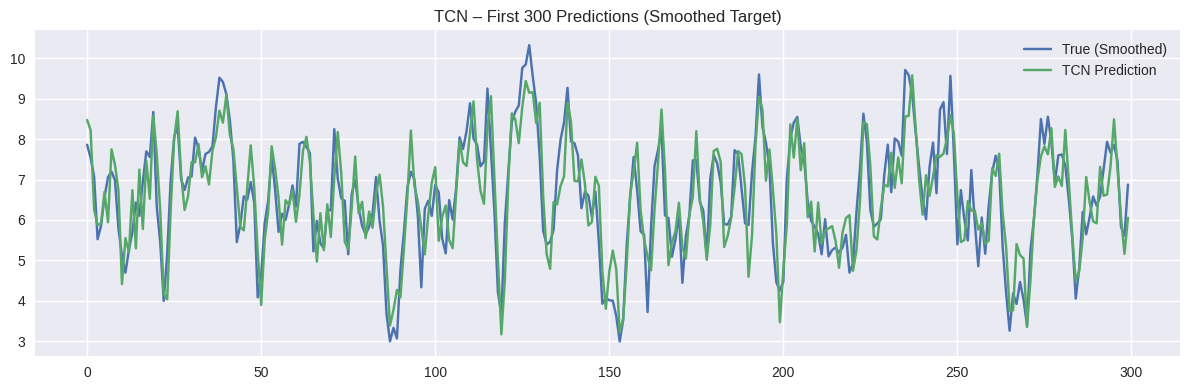

In [21]:
# TCN EVALUATION

start = time.time() # start time

y_pred_tcn_scaled = tcn_model.predict(X_test_dl)

tcn_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Insert predicted scaled y back into the scaled feature row
    so inverse_transform() can restore the true kW value.
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

# Build inverse-transformed predictions & ground truth
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(x_last, y_pred_tcn_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i],           scaler, target_idx)

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Metrics
mse_tcn = mean_squared_error(y_true, y_pred)
rmse_tcn = np.sqrt(mse_tcn)
mae_tcn = mean_absolute_error(y_true, y_pred)
mape_tcn = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_tcn = r2_score(y_true, y_pred)

print("TCN RMSE:", rmse_tcn)
print("TCN MAE :", mae_tcn)
print("TCN MAPE :", mape_tcn)
print("TCN R2 SCORE:", r2_tcn)
print(f"\nTCN testing time: {tcn_test_time:.2f} seconds\n")

# Plot TCN predictions
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='TCN Prediction')
plt.title("TCN – First 300 Predictions (Smoothed Target)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "tcn_predict_base.png"), dpi=150)
plt.show()


# Section 12. Transformer Model

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - loss: 0.0362 - val_loss: 0.0208
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0191 - val_loss: 0.0174
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0183 - val_loss: 0.0174
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0179 - val_loss: 0.0174
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0178 - val_loss: 0.0173
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0177 - val_loss: 0.0174
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0174 - val_loss: 0.0137
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0126 - val_loss: 0.0119
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0118 - val_loss: 0.0119
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 12

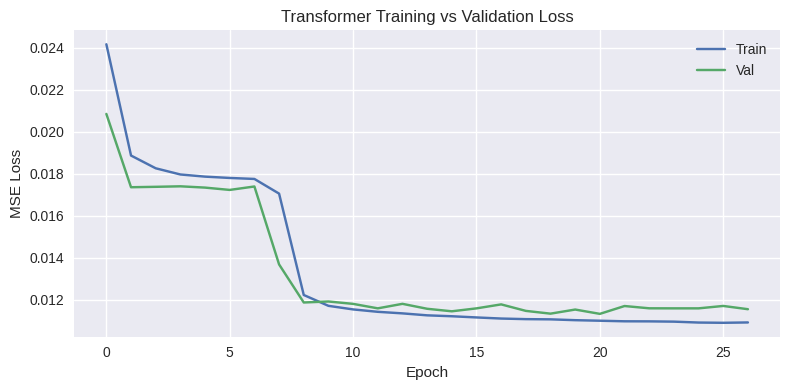

In [22]:
# TRANSFORMER TRAINING

early_transformer = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_transformer = transformer_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_transformer],
    verbose=1
)

tr_train_time = time.time() - start
print(f"\nTransformer training time: {tr_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_transformer.history['loss'], label='Train')
plt.plot(history_transformer.history['val_loss'], label='Val')
plt.title('Transformer Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "transformer_base.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Transformer RMSE: 1.029405498970337
Transformer MAE : 0.8336951502419301
Transformer MAPE : 13.921094378099127
Transformer R2 SCORE: 0.5122958992030859

Transformer testing time: 1.33 seconds



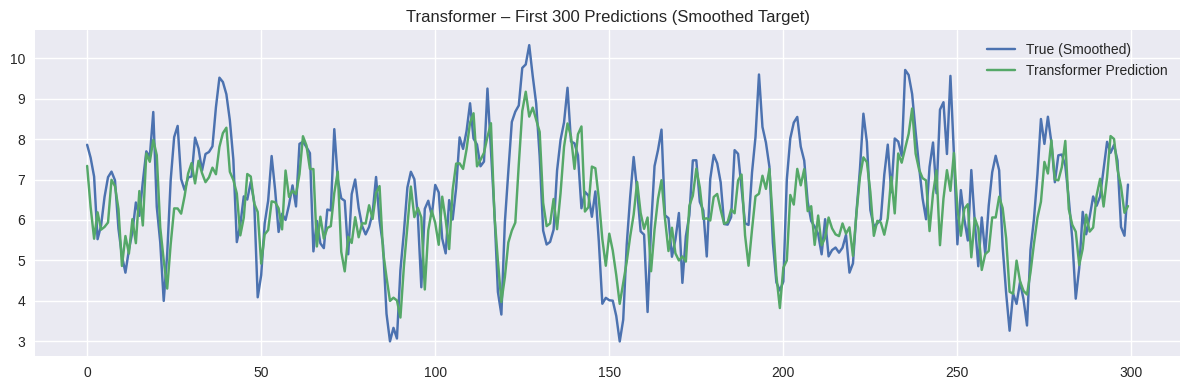

In [23]:
# TRANSFORMER EVALUATION

start = time.time() # start time

y_pred_transformer_scaled = transformer_model.predict(X_test_dl)

tr_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Rebuild a full row with scaled y inserted so MinMaxScaler can invert properly.
    x_window_last: last timestep feature vector from the window
    y_scaled_value: model prediction (scaled)
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

# Build inverse-transformed results
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(x_last, y_pred_transformer_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i],                 scaler, target_idx)

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Metrics
mse_tr = mean_squared_error(y_true, y_pred)
rmse_tr = np.sqrt(mse_tr)
mae_tr  = mean_absolute_error(y_true, y_pred)
mape_tr = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_tr   = r2_score(y_true, y_pred)

print("Transformer RMSE:", rmse_tr)
print("Transformer MAE :", mae_tr)
print("Transformer MAPE :", mape_tr)
print("Transformer R2 SCORE:", r2_tr)
print(f"\nTransformer testing time: {tr_test_time:.2f} seconds\n")

# Plot prediction window
plt.figure(figsize=(12, 4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='Transformer Prediction')
plt.title("Transformer – First 300 Predictions (Smoothed Target)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "transformer_predict_base.png"), dpi=150)
plt.show()


# Section 13. RNN Model

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.1022 - val_loss: 0.0082
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0118 - val_loss: 0.0071
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0085 - val_loss: 0.0070
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0074 - val_loss: 0.0064
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0069 - val_loss: 0.0066
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 12/40
1094/1094 ━━━━━━━

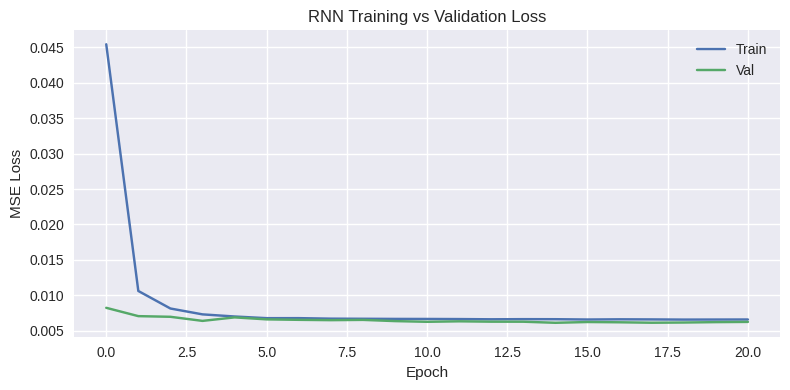

In [24]:
# RNN TRAINING

early_rnn = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=6, restore_best_weights=True
)

start = time.time() # start time

history_rnn = rnn_model.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_rnn],
    verbose=1
)

rnn_train_time = time.time() - start
print(f"\nRNN training time: {rnn_train_time:.2f} seconds")

plt.figure(figsize=(8, 4))
plt.plot(history_rnn.history["loss"], label="Train")
plt.plot(history_rnn.history["val_loss"], label="Val")
plt.title("RNN Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "rnn_base.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RNN RMSE: 0.7633504834512707
RNN MAE : 0.6561810193631119
RNN MAPE : 11.072247982537842
RNN R2 SCORE: 0.7318168981884816

RNN testing time: 1.13 seconds



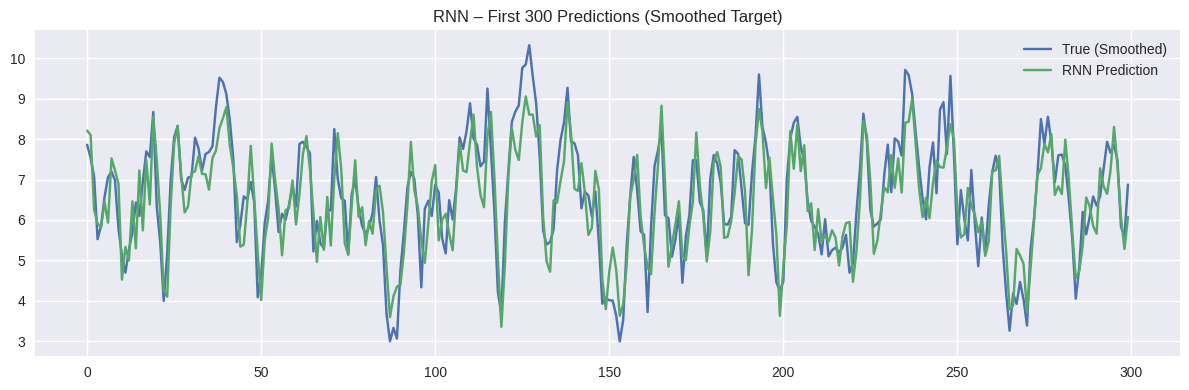

In [25]:
# RNN EVALUATION

start = time.time() # start time

y_pred_rnn_scaled = rnn_model.predict(X_test_dl)

rnn_test_time = time.time() - start

y_pred, y_true = [], []
for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]
    pred_val = invert_target(x_last, y_pred_rnn_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i],          scaler, target_idx)
    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#Metrics
mse_rnn = mean_squared_error(y_true, y_pred)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn  = mean_absolute_error(y_true, y_pred)
mape_rnn = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_rnn = r2_score(y_true, y_pred)

print("RNN RMSE:", rmse_rnn)
print("RNN MAE :", mae_rnn)
print("RNN MAPE :", mape_rnn)
print("RNN R2 SCORE:", r2_rnn)
print(f"\nRNN testing time: {rnn_test_time:.2f} seconds\n")

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(y_true[:300], label="True (Smoothed)")
plt.plot(y_pred[:300], label="RNN Prediction")
plt.title("RNN – First 300 Predictions (Smoothed Target)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "rnn_predict_base.png"), dpi=150)
plt.show()

# Section 14. Hyper perameter Tunning (Keras Tuner)

In [26]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 8.4 MB/s eta 0:00:00


In [27]:
import keras_tuner as kt

## 14.1 LSTM Model

In [ ]:
# LSTM Hyperparameter Tuner

def lstm_hyperbuilder(hp):
    units1 = hp.Int('units1', min_value=32, max_value=256, step=32)
    units2 = hp.Int('units2', min_value=16, max_value=128, step=16)
    dropout_rate = hp.Float('dropout', 0.0, 0.5, step=0.1)
    lr = hp.Choice('learning_rate', [1e-4, 3e-4, 1e-3])

    model = Sequential([
        LSTM(units1, return_sequences=True, input_shape=(WINDOW, n_features)),
        Dropout(dropout_rate),
        LSTM(units2),
        Dense(64, activation='relu'),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    return model

tuner_lstm = kt.Hyperband(
    lstm_hyperbuilder,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='kt_lstm',
    project_name='lstm_tuning'
)

tuner_lstm.search(X_train_dl, y_train_dl,
                  validation_data=(X_val_dl, y_val_dl),
                  callbacks=[EarlyStopping(patience=5)])

In [ ]:
best_hp_lstm = tuner_lstm.get_best_hyperparameters(1)[0]
best_model_lstm = tuner_lstm.get_best_models(1)[0]
best_model_lstm.summary()


In [28]:
# UPDATED LSTM MODEL (Matches KerasTuner Best Model)
# Build model with tuned parameters

lstm_model_keras = build_lstm_improved(WINDOW, n_features, 192, 16, 0.0, 1e-3)
lstm_model_keras.summary()
save_model_summary(lstm_model_keras, "lstm_keras_summary.txt")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 8, 192)         │       155,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 192)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │        13,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,665 (662.75 KB)

 Trainable params: 169,665 (662.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 0.0184 - val_loss: 0.0076
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 26ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 12

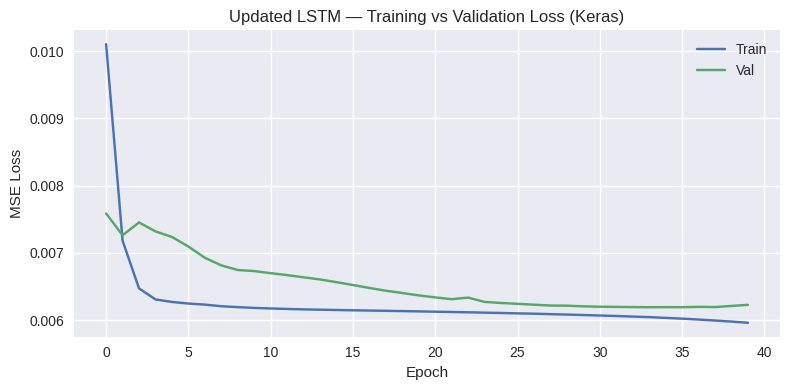

In [29]:
# TRAIN UPDATED LSTM MODEL

early_lstm = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_lstm = lstm_model_keras.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs= 40,
    batch_size=32,
    callbacks=[early_lstm],
    verbose=1
)

lstm_keras_train_time = time.time() - start
print(f"\nLSTM training time: {lstm_keras_train_time:.2f} seconds")

# Plot training curve
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Val')
plt.title("Updated LSTM — Training vs Validation Loss (Keras)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "lstm_keras.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
Updated (Best) LSTM RMSE: 0.7629738084375742
Updated (Best) LSTM MAE : 0.6601899245599278
Updated (Best) LSTM MAPE : 10.992894483532128
Updated (Best) LSTM R2 SCORE: 0.728330892550233

LSTM testing time: 3.13 seconds



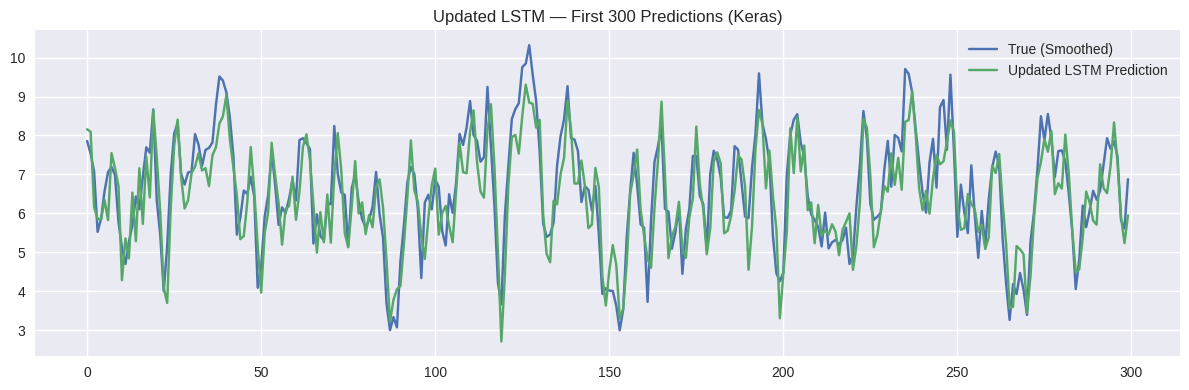

In [30]:
# PREDICTION + METRICS FOR UPDATED LSTM

start = time.time() # start time

y_pred_scaled = lstm_model_keras.predict(X_test_dl)

lstm_keras_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

# Build lists
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(x_last, y_pred_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i], scaler, target_idx)

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Metrics
mse_lstm_keras = mean_squared_error(y_true, y_pred)
rmse_lstm_keras = np.sqrt(mse_lstm)
mae_lstm_keras = mean_absolute_error(y_true, y_pred)
mape_lstm_keras = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_lstm_keras = r2_score(y_true, y_pred)

print("Updated (Best) LSTM RMSE:", rmse_lstm_keras)
print("Updated (Best) LSTM MAE :", mae_lstm_keras)
print("Updated (Best) LSTM MAPE :", mape_lstm_keras)
print("Updated (Best) LSTM R2 SCORE:", r2_lstm_keras)
print(f"\nLSTM testing time: {lstm_keras_test_time:.2f} seconds\n")

# Plot results
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='Updated LSTM Prediction')
plt.title("Updated LSTM — First 300 Predictions (Keras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "lstm_keras_predict.png"), dpi=150)
plt.show()


## 14.2 GRU Model

In [ ]:
# GRU Hyperparameter Tuner

import keras_tuner as kt

def gru_hyperbuilder(hp):
    units = hp.Int('units', min_value=32, max_value=256, step=32)
    dropout_rate = hp.Float('dropout', 0.0, 0.5, step=0.1)
    lr = hp.Choice('learning_rate', [1e-4, 3e-4, 1e-3])

    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(WINDOW, n_features)),
        Dropout(dropout_rate),
        GRU(int(units/2)),
        Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    return model

tuner_gru = kt.Hyperband(
    gru_hyperbuilder,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='kt_gru',
    project_name='gru_tuning'
)

tuner_gru.search(X_train_dl, y_train_dl,
                 validation_data=(X_val_dl, y_val_dl),
                 callbacks=[EarlyStopping(patience=5)])

In [ ]:
best_hp_gru = tuner_gru.get_best_hyperparameters(1)[0]
best_model_gru = tuner_gru.get_best_models(1)[0]
best_model_gru.summary()

In [31]:
# BEST GRU MODEL (Matches KerasTuner Best Architecture)

# Instantiate the best GRU
gru_model_keras = build_gru(WINDOW, n_features, 128, 64, 0.0, 1e-3)
gru_model_keras.summary()
save_model_summary(gru_model_keras, "gru_keras_summary.txt")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 8, 128)         │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,689 (354.25 KB)

 Trainable params: 90,689 (354.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.0123 - val_loss: 0.0079
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 23s 21ms/step - loss: 0.0068 - val_loss: 0.0075
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0064 - val_loss: 0.0073
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 12

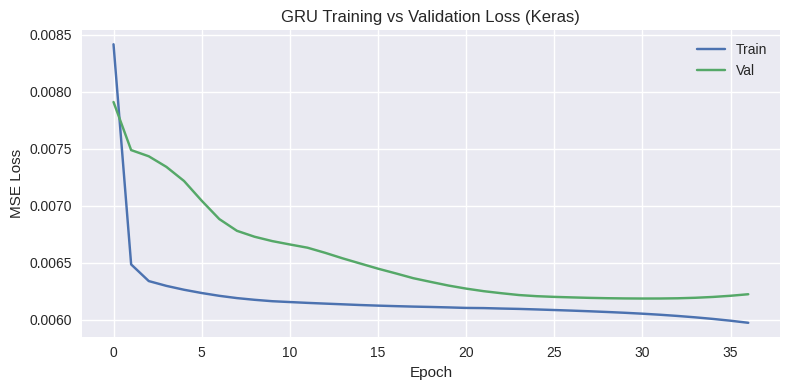

In [32]:
# GRU TRAINING

early_gru = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_gru = gru_model_keras.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_gru],
    verbose=1
)

gru_keras_train_time = time.time() - start
print(f"\nGRU training time: {gru_keras_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Val')
plt.title('GRU Training vs Validation Loss (Keras)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "gru_keras.png"), dpi=150)
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
GRU RMSE: 0.7571448171972558
GRU MAE : 0.6602084467620819
GRU MAPE : 10.979409981048196
GRU R2 SCORE: 0.7284846377800707

GRU testing time: 2.25 seconds



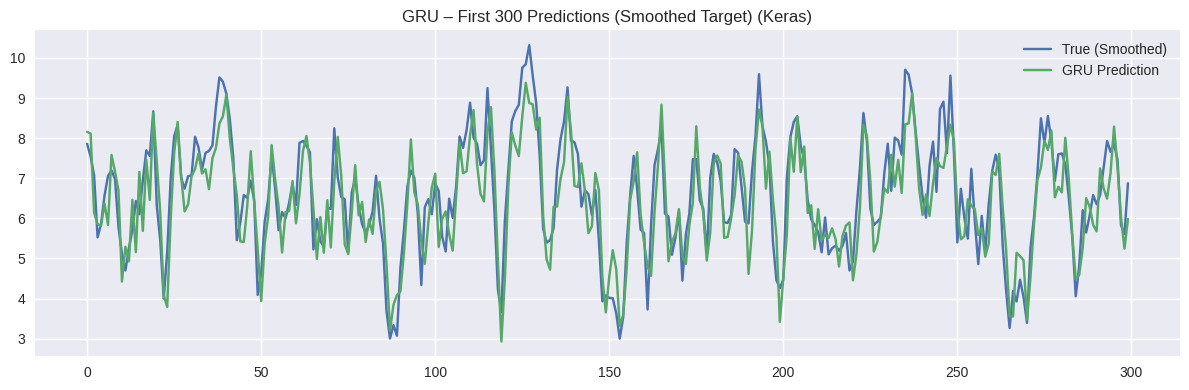

In [33]:
# GRU PREDICTION + INVERSE TRANSFORM

start = time.time() # start time

y_pred_gru_scaled = gru_model_keras.predict(X_test_dl)

gru_keras_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

# Build predictions
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(
        x_last, y_pred_gru_scaled[i], scaler, target_idx
    )
    true_val = invert_target(
        x_last, y_test_dl[i], scaler, target_idx
    )

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#Metrics
mse_gru_keras = mean_squared_error(y_true, y_pred)
rmse_gru_keras = np.sqrt(mse_gru)
mae_gru_keras = mean_absolute_error(y_true, y_pred)
mape_gru_keras = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_gru_keras = r2_score(y_true, y_pred)

print("GRU RMSE:", rmse_gru_keras)
print("GRU MAE :", mae_gru_keras)
print("GRU MAPE :", mape_gru_keras)
print("GRU R2 SCORE:", r2_gru_keras)
print(f"\nGRU testing time: {gru_keras_test_time:.2f} seconds\n")

# Plot first 300 predictions
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='GRU Prediction')
plt.title("GRU – First 300 Predictions (Smoothed Target) (Keras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "gru_keras_predict.png"), dpi=150)
plt.show()

## 14.3 TCN Model

In [ ]:
# TCN Hyperparameter Tuner

def tcn_hyperbuilder(hp):
    filters = hp.Int('filters', min_value=16, max_value=64, step=16)
    kernel_size = hp.Choice('kernel_size', [2, 3, 5])
    lr = hp.Choice('learning_rate', [1e-4, 3e-4, 1e-3])

    inp = Input(shape=(WINDOW, n_features))

    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=1)(inp)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=2)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv1D(filters=filters, kernel_size=kernel_size, padding='causal', dilation_rate=4)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    return model

tuner_tcn = kt.Hyperband(
    tcn_hyperbuilder,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='kt_tcn',
    project_name='tcn_tuning'
)

tuner_tcn.search(X_train_dl, y_train_dl,
                 validation_data=(X_val_dl, y_val_dl),
                 callbacks=[EarlyStopping(patience=5)])

In [ ]:
best_hp_tcn = tuner_tcn.get_best_hyperparameters(1)[0]
best_model_tcn = tuner_tcn.get_best_models(1)[0]
best_model_tcn.summary()

In [37]:
# BEST TCN MODEL (Matches KerasTuner Best Architecture)

# Build the best TCN
tcn_model_keras = build_tcn(WINDOW, n_features, 9, 3, 1e-3)
tcn_model_keras.summary()
save_model_summary(tcn_model_keras, "tcn_keras_summary.txt")

Model: "TCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 8, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 8, 9)           │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 9)           │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 8, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 8, 9)           │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 9)           │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 8, 9)           │           252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 9)           │            36 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 9)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,163 (4.54 KB)

 Non-trainable params: 54 (216.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0188 - val_loss: 0.0083
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0082 - val_loss: 0.0067
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0073 - val_loss: 0.0064
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0069 - val_loss: 0.0063
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0068 - val_loss: 0.0063
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 12/40
1094/1094 ━━━━━━━━

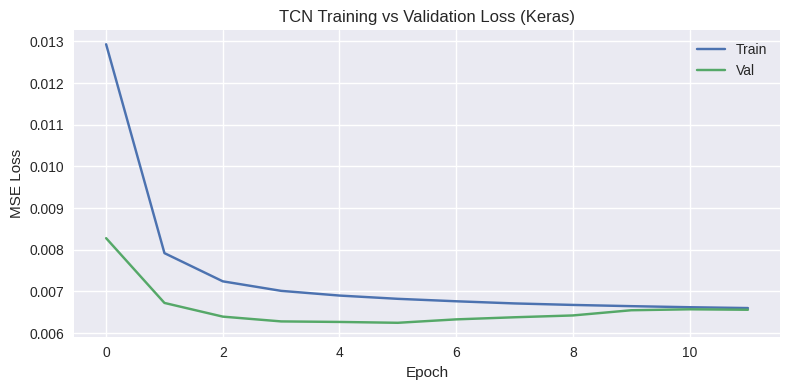

In [38]:
# TCN TRAINING

early_tcn = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_tcn = tcn_model_keras.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_tcn],
    verbose=1
)

tcn_keras_train_time = time.time() - start
print(f"\nTNC training time: {tcn_keras_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history_tcn.history['loss'], label='Train')
plt.plot(history_tcn.history['val_loss'], label='Val')
plt.title('TCN Training vs Validation Loss (Keras)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "tcn_keras.png"), dpi=150)
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TCN RMSE: 0.7692965220142335
TCN MAE : 0.6591540627222129
TCN MAPE : 11.309958081576632
TCN R2 SCORE: 0.7286752185960357

TNC testing time: 0.80 seconds



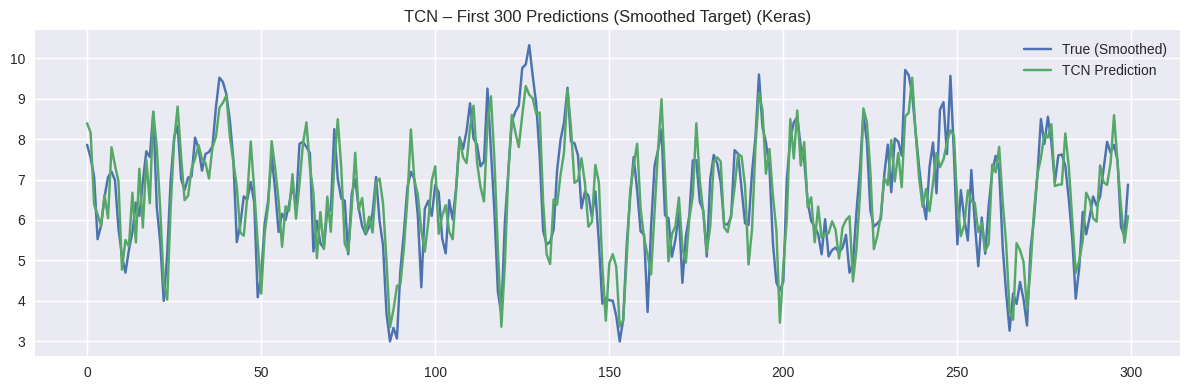

In [39]:
# TCN PREDICTION + INVERSE TRANSFORM

start = time.time() # start time

y_pred_tcn_scaled = tcn_model_keras.predict(X_test_dl)

tcn_keras_test_time = time.time() - start

# Target column index for reverse scaling
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Rebuild a full scaled feature vector with the prediction inserted
    so MinMaxScaler.inverse_transform() works correctly.
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]


# Build inverse-transformed predictions
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(
        x_last, y_pred_tcn_scaled[i],
        scaler, target_idx
    )
    true_val = invert_target(
        x_last, y_test_dl[i],
        scaler, target_idx
    )

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#Metrics
mse_tcn_keras = mean_squared_error(y_true, y_pred)
rmse_tcn_keras = np.sqrt(mse_tcn)
mae_tcn_keras = mean_absolute_error(y_true, y_pred)
mape_tcn_keras = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_tcn_keras = r2_score(y_true, y_pred)

print("TCN RMSE:", rmse_tcn_keras)
print("TCN MAE :", mae_tcn_keras)
print("TCN MAPE :", mape_tcn_keras)
print("TCN R2 SCORE:", r2_tcn_keras)
print(f"\nTNC testing time: {tcn_keras_test_time:.2f} seconds\n")

# First 300 predictions plot
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='TCN Prediction')
plt.title("TCN – First 300 Predictions (Smoothed Target) (Keras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "tcn_keras_predict.png"), dpi=150)
plt.show()


## 14.4 Transformer Model

In [40]:
# TRANSFORMER Hyperparameter Tuner

def transformer_hyperbuilder(hp):

    # Hyperparameters to search
    d_model      = hp.Int('d_model',     min_value=32,  max_value=128, step=32)
    num_heads    = hp.Choice('num_heads', values=[2, 4, 8])
    ff_dim       = hp.Int('ff_dim',      min_value=64,  max_value=256, step=64)
    dropout_rate = hp.Choice('dropout',  values=[0.0, 0.1, 0.2])
    lr           = hp.Choice('lr',       values=[1e-4, 3e-4, 1e-3])

    # Input
    inp = Input(shape=(WINDOW, n_features))

    # Linear projection to d_model
    x = Dense(d_model)(inp)

    # ---- Transformer block ----
    # Multi-head self attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model // num_heads
    )(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = LayerNormalization(epsilon=1e-6)(x + attn_output)   # residual

    # Feed-forward sublayer
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(d_model)(ff_output)
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)     # residual

    # ---- Output head ----
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='mse'
    )
    return model


# Create the tuner
tuner_transformer = kt.Hyperband(
    transformer_hyperbuilder,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='kt_transformer',
    project_name='transformer_tuning'
)

# Run the search
tuner_transformer.search(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    callbacks=[EarlyStopping(patience=5)],
    verbose=1
)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |128               |d_model
4                 |4                 |num_heads
128               |128               |ff_dim
0.2               |0.2               |dropout
0.001             |0.001             |lr
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


KeyboardInterrupt: 

In [ ]:
best_hp_transformer  = tuner_transformer.get_best_hyperparameters(1)[0]
best_model_transformer = tuner_transformer.get_best_models(1)[0]

best_model_transformer.summary()

In [41]:
# BEST TRANSFORMER MODEL (Matches KerasTuner Best Architecture)

# Build and show summary
transformer_model_keras = build_transformer(WINDOW, n_features, 128, 8, 192, 0.0, 1e-3)
transformer_model_keras.summary()
save_model_summary(transformer_model_keras, "transformer_keras_summary.txt")

Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 8, 9)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8, 128)    │      1,280 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 128)    │     66,048 │ dense_5[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 8, 128)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 8, 128)    │          0 │ dense_5[0][0],    │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 128)    │        256 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 8, 192)    │     24,768 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 8, 192)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8, 128)    │     24,704 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 8, 128)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 8, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 128)    │        256 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │      4,128 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │         33 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 121,473 (474.50 KB)

 Trainable params: 121,473 (474.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - loss: 0.0394 - val_loss: 0.0178
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0179 - val_loss: 0.0178
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0176 - val_loss: 0.0179
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0175 - val_loss: 0.0173
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.0141 - val_loss: 0.0137
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 25ms/step - loss: 0.0121 - val_loss: 0.0143
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0117 - val_loss: 0.0139
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0116 - val_loss: 0.0134
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - loss: 0.0115 - val_loss: 0.0130
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0114 - val_loss: 0.0128
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step - loss: 0.0113 - val_loss: 0.0127
Epoch 12

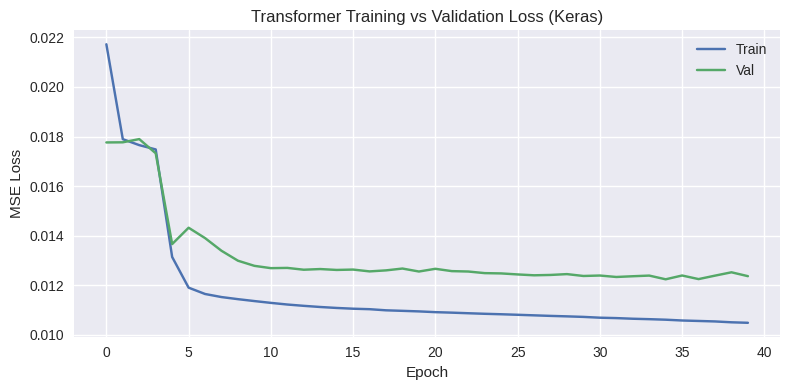

In [42]:
# TRANSFORMER TRAINING

early_transformer = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_transformer = transformer_model_keras.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_transformer],
    verbose=1
)

tr_keras_train_time = time.time() - start
print(f"\nTransformer training time: {tr_keras_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_transformer.history['loss'], label='Train')
plt.plot(history_transformer.history['val_loss'], label='Val')
plt.title('Transformer Training vs Validation Loss (Keras)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "transformer_keras.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Transformer RMSE: 1.029405498970337
Transformer MAE : 0.8336951502419301
Transformer MAPE: 13.921094351959729
Transformer R2 SCORE: 0.5122958992030859

Transformer testing time: 1.27 seconds



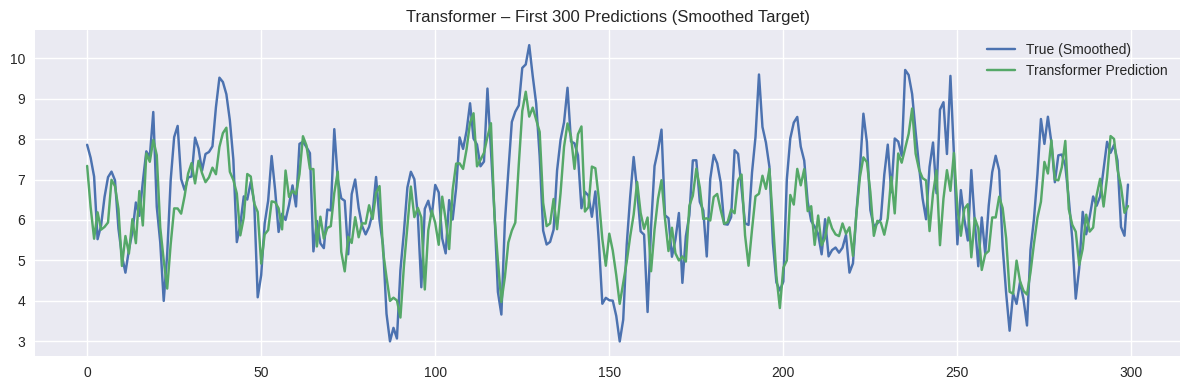

In [43]:
# TRANSFORMER EVALUATION

from sklearn.metrics import mean_squared_error, mean_absolute_error

start = time.time() # start time

y_pred_transformer_scaled = transformer_model.predict(X_test_dl)

tr_keras_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Rebuilds a full row with scaled y inserted so MinMaxScaler
    can invert properly.
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]


# Build inverse-transformed results
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]     # last timestep of window

    pred_val = invert_target(
        x_last,
        y_pred_transformer_scaled[i],
        scaler,
        target_idx
    )

    true_val = invert_target(
        x_last,
        y_test_dl[i],
        scaler,
        target_idx
    )

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Metrics
mse_tr_keras = mean_squared_error(y_true, y_pred)
rmse_tr_keras = np.sqrt(mse_tr)
mae_tr_keras = mean_absolute_error(y_true, y_pred)
mape_tr_keras = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2_tr_keras = r2_score(y_true, y_pred)

print("Transformer RMSE:", rmse_tr_keras)
print("Transformer MAE :", mae_tr_keras)
print("Transformer MAPE:", mape_tr_keras)
print("Transformer R2 SCORE:", r2_tr_keras)
print(f"\nTransformer testing time: {tr_keras_test_time:.2f} seconds\n")

# Plot prediction window
plt.figure(figsize=(12, 4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='Transformer Prediction')
plt.title("Transformer – First 300 Predictions (Smoothed Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "transformer_keras_predict.png"), dpi=150)
plt.show()


## 14.5 RNN Model

In [ ]:
# =============================================================
# RNN Hyperparameter Tuner
# =============================================================

def rnn_hyperbuilder(hp):

    # Hyperparameters to search
    units1 = hp.Int("units1", min_value=32, max_value=128, step=32)
    units2 = hp.Int("units2", min_value=16, max_value=64, step=16)
    dropout_rate = hp.Choice("dropout_rate", [0.1, 0.2, 0.3])
    lr = hp.Choice("learning_rate", [1e-4, 3e-4, 1e-3])

    inp = Input(shape=(WINDOW, n_features))

    x = tf.keras.layers.SimpleRNN(
        units1,
        return_sequences=True
    )(inp)
    x = Dropout(dropout_rate)(x)

    x = tf.keras.layers.SimpleRNN(units2)(x)
    x = Dropout(dropout_rate)(x)

    out = Dense(1)(x)

    model = Model(inputs=inp, outputs=out)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse"
    )

    return model


# Create tuner
tuner_rnn = kt.Hyperband(
    rnn_hyperbuilder,
    objective="val_loss",
    max_epochs=20,
    factor=3,
    directory="kt_rnn",
    project_name="rnn_tuning"
)

# Run search
tuner_rnn.search(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    callbacks=[EarlyStopping(patience=5)]
)

In [ ]:
best_hp_rnn = tuner_rnn.get_best_hyperparameters(1)[0]
best_model_rnn = tuner_rnn.get_best_models(1)[0]

best_model_rnn.summary()

In [44]:
#Best RNN via Grid-Search
rnn_model_keras = build_rnn(WINDOW, n_features, units1=64, units2=64, dropout_rate=0.2, lr=1e-3)
rnn_model_keras.summary()
save_model_summary(rnn_model_keras, "rnn_keras_summary.txt")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 8, 64)          │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,057 (51.00 KB)

 Trainable params: 13,057 (51.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.1352 - val_loss: 0.0072
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0132 - val_loss: 0.0074
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.0068 - val_loss: 0.0065
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 12/40
1094/1094 ━━━━━━

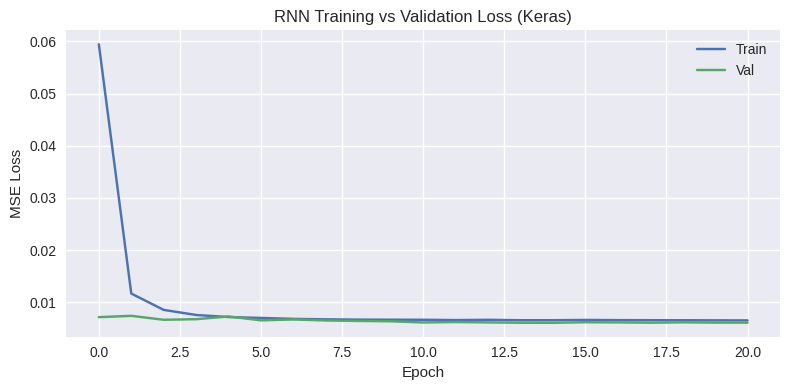

In [45]:
# RNN TRAINING

early_rnn = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=6, restore_best_weights=True
)

start = time.time() # start time

history_rnn = rnn_model_keras.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_rnn],
    verbose=1
)

rnn_keras_train_time = time.time() - start
print(f"\nRNN training time: {rnn_keras_train_time:.2f} seconds")

plt.figure(figsize=(8, 4))
plt.plot(history_rnn.history["loss"], label="Train")
plt.plot(history_rnn.history["val_loss"], label="Val")
plt.title("RNN Training vs Validation Loss (Keras)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "rnn_keras.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RNN RMSE: 0.7633504834512707
RNN MAE : 0.6539005937906872
RNN MAPE : 11.049462760716262
RNN R2 SCORE: 0.734539889447407

RNN testing time: 1.10 seconds



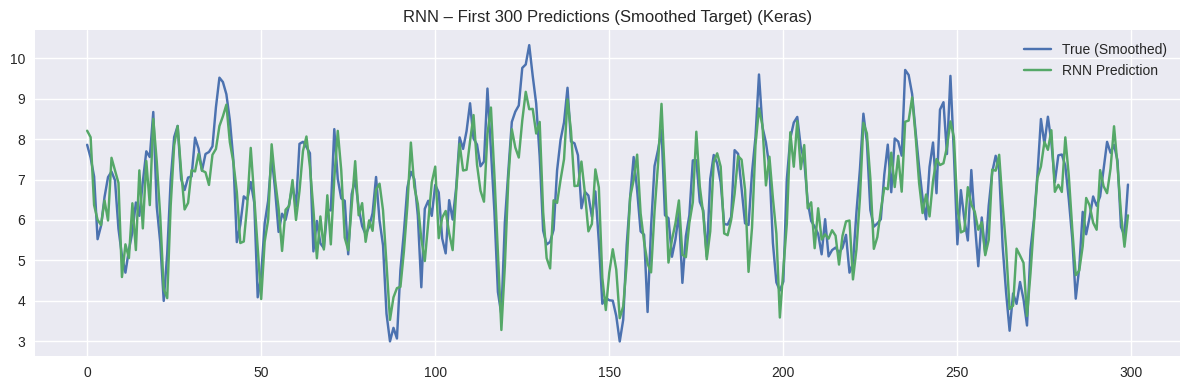

In [46]:
# RNN EVALUATION

start = time.time() # start time

y_pred_rnn_scaled = rnn_model_keras.predict(X_test_dl)

rnn_keras_test_time = time.time() - start

y_pred, y_true = [], []
for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]
    pred_val = invert_target(x_last, y_pred_rnn_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i],          scaler, target_idx)
    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#Metrics
mse_rnn_keras = mean_squared_error(y_true, y_pred)
rmse_rnn_keras = np.sqrt(mse_rnn)
mae_rnn_keras = mean_absolute_error(y_true, y_pred)
mape_rnn_keras = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_rnn_keras = r2_score(y_true, y_pred)

print("RNN RMSE:", rmse_rnn_keras)
print("RNN MAE :", mae_rnn_keras)
print("RNN MAPE :", mape_rnn_keras)
print("RNN R2 SCORE:", r2_rnn_keras)
print(f"\nRNN testing time: {rnn_keras_test_time:.2f} seconds\n")

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(y_true[:300], label="True (Smoothed)")
plt.plot(y_pred[:300], label="RNN Prediction")
plt.title("RNN – First 300 Predictions (Smoothed Target) (Keras)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "rnn_predict_keras.png"), dpi=150)
plt.show()

# Section 15 Grid-Search

In [ ]:


def tune_keras_model(build_fn, X_train, y_train, X_val, y_val, param_grid,
                     max_epochs=25, batch_size=64):
    """
    build_fn(params) -> compiled Keras model
    param_grid: dict of {name: [values,...]}
    Returns: best_params, best_val_rmse
    """
    keys = list(param_grid.keys())
    best_rmse = np.inf
    best_params = None

    for values in itertools.product(*param_grid.values()):
        params = dict(zip(keys, values))
        print("\nTesting params:", params)

        model = build_fn(**params)

        early = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
            verbose=0
        )

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=max_epochs,
            batch_size=params.get("batch_size", batch_size),
            callbacks=[early],
            verbose=0
        )

        val_rmse = np.sqrt(min(history.history["val_loss"]))
        print(f"  val_RMSE = {val_rmse:.4f}")

        if val_rmse < best_rmse:
            best_rmse = val_rmse
            best_params = params

    print("\nBest params:", best_params)
    print("Best val_RMSE:", best_rmse)
    return best_params, best_rmse


## 15.1 LSTM Grid-Search

In [ ]:
# Use Grid-Search for LSTM
best_lstm_params, best_lstm_rmse = tune_keras_model(
    lambda **p: build_lstm_improved(WINDOW, n_features, **p),
    X_train_dl, y_train_dl,
    X_val_dl, y_val_dl,
    param_grid={
        "units1": [64, 128],
        "units2": [32, 64],
        "dropout_rate": [0.0, 0.1, 0.3],
        "lr": [1e-3, 3e-4]
    }
)

In [34]:
# Build model with grid-searched parameters

lstm_model_grid = build_lstm_improved(WINDOW, n_features, 128, 32, 0.0, 1e-3)
lstm_model_grid.summary()
save_model_summary(lstm_model_grid, "lstm_grid_summary.txt")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 8, 128)         │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,441 (365.00 KB)

 Trainable params: 93,441 (365.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.0180 - val_loss: 0.0078
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0074 - val_loss: 0.0079
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0071 - val_loss: 0.0073
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0064 - val_loss: 0.0074
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0063 - val_loss: 0.0073
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0063 - val_loss: 0.0070
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0062 - val_loss: 0.0068
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0062 - val_loss: 0.0067
Epoch 12

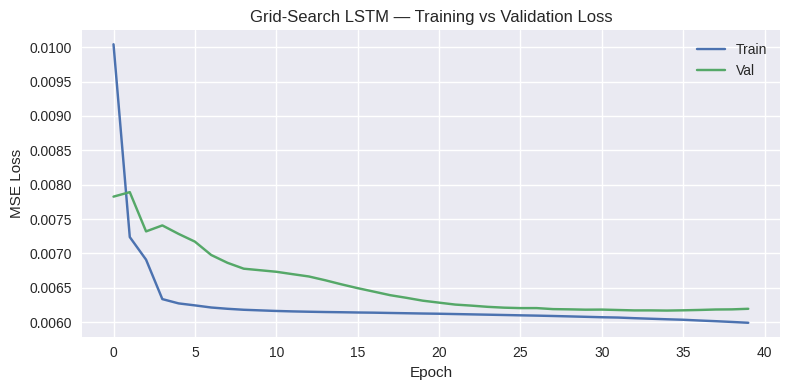

In [35]:
# TRAIN UPDATED LSTM MODEL

early_lstm = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_lstm = lstm_model_grid.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs= 40,
    batch_size=32,
    callbacks=[early_lstm],
    verbose=1
)

lstm_grid_train_time = time.time() - start
print(f"\nLSTM training time: {lstm_grid_train_time:.2f} seconds")

# Plot training curve
plt.figure(figsize=(8,4))
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Val')
plt.title("Grid-Search LSTM — Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "lstm_grid.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Updated (Best) LSTM RMSE: 0.7666763011306118
Updated (Best) LSTM MAE : 0.6597274826413416
Updated (Best) LSTM MAPE : 11.0091986441939
Updated (Best) LSTM R2 SCORE: 0.7294749304360268

LSTM testing time: 2.01 seconds



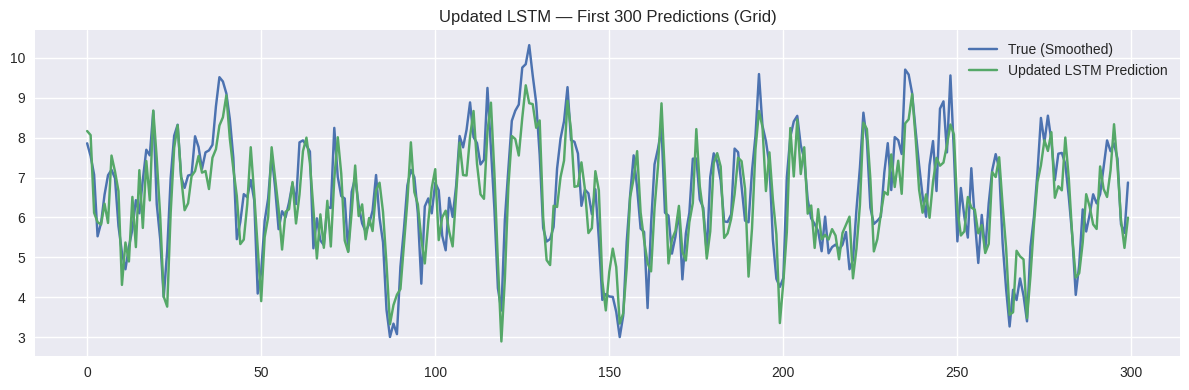

In [36]:
# PREDICTION + METRICS FOR UPDATED LSTM

start = time.time() # start time

y_pred_scaled = lstm_model_grid.predict(X_test_dl)

lstm_grid_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

# Build lists
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(x_last, y_pred_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i], scaler, target_idx)

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Metrics
mse_lstm_grid = mean_squared_error(y_true, y_pred)
rmse_lstm_grid = np.sqrt(mse_lstm_grid)
mae_lstm_grid = mean_absolute_error(y_true, y_pred)
mape_lstm_grid = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_lstm_grid = r2_score(y_true, y_pred)

print("Updated (Best) LSTM RMSE:", rmse_lstm_grid)
print("Updated (Best) LSTM MAE :", mae_lstm_grid)
print("Updated (Best) LSTM MAPE :", mape_lstm_grid)
print("Updated (Best) LSTM R2 SCORE:", r2_lstm_grid)
print(f"\nLSTM testing time: {lstm_grid_test_time:.2f} seconds\n")

# Plot results
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='Updated LSTM Prediction')
plt.title("Updated LSTM — First 300 Predictions (Grid)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "lstm_grid_predict.png"), dpi=150)
plt.show()


## 15.2 GRU Grid-Search

In [ ]:
# Use Grid-Search for GRU
param_grid_gru = {
    "units1": [64, 128],
    "units2": [32, 64],
    "dropout_rate": [0.1, 0.3],
    "lr": [1e-3, 3e-4],
}

best_gru_params, best_gru_rmse = tune_keras_model(
    lambda **p: build_gru(WINDOW, n_features, **p),
    X_train_dl, y_train_dl,
    X_val_dl, y_val_dl,
    param_grid_gru
)

In [47]:
# Best GRU via Grid-Search
gru_model_grid = build_gru(WINDOW, n_features, 128, 64, 0.1, 1e-3)
gru_model_grid.summary()
save_model_summary(gru_model_grid, "gru_grid_summary.txt")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 8, 128)         │        53,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,689 (354.25 KB)

 Trainable params: 90,689 (354.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - loss: 0.0123 - val_loss: 0.0076
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0067 - val_loss: 0.0074
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0065 - val_loss: 0.0067
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0064 - val_loss: 0.0069
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 20ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0064 - val_loss: 0.0065
Epoch 12

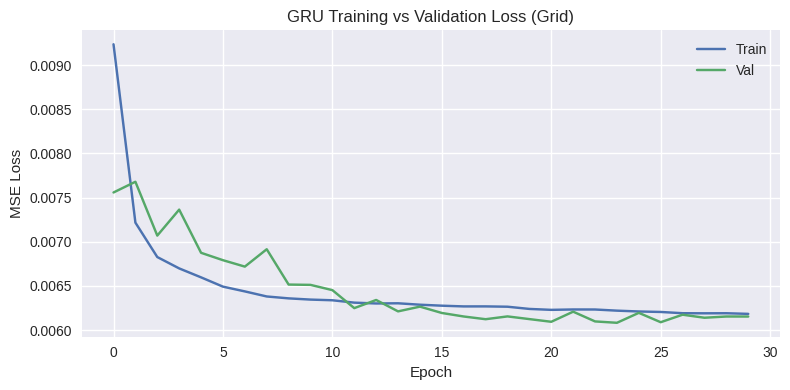

In [48]:
# GRU TRAINING

early_gru = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_gru = gru_model_grid.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_gru],
    verbose=1
)

gru_grid_train_time = time.time() - start
print(f"\nGRU training time: {gru_grid_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Val')
plt.title('GRU Training vs Validation Loss (Grid)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "gru_grid.png"), dpi=150)
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
GRU RMSE: 0.7571448171972558
GRU MAE : 0.6537260035594303
GRU MAPE : 10.996282534582145
GRU R2 SCORE: 0.7346215212061404

GRU testing time: 2.03 seconds



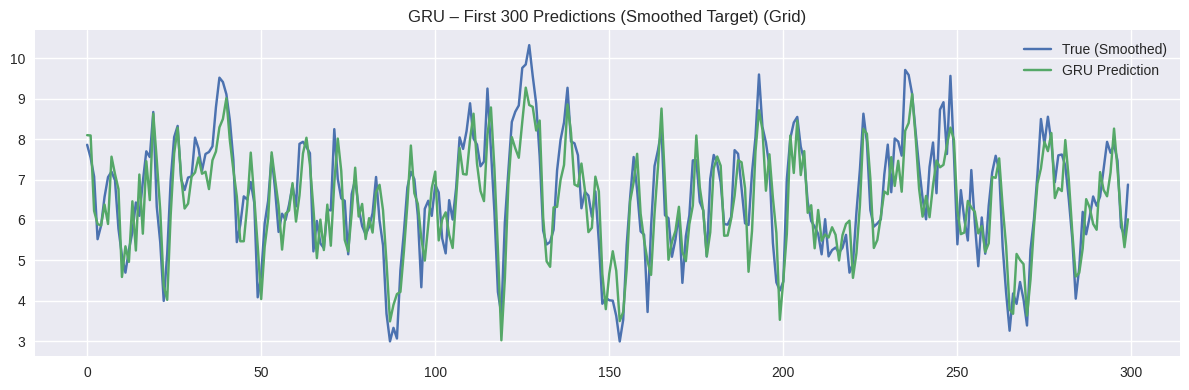

In [49]:
# GRU PREDICTION + INVERSE TRANSFORM

start = time.time() # start time

y_pred_gru_scaled = gru_model_grid.predict(X_test_dl)

gru_grid_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]

# Build predictions
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(
        x_last, y_pred_gru_scaled[i], scaler, target_idx
    )
    true_val = invert_target(
        x_last, y_test_dl[i], scaler, target_idx
    )

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#Metrics
mse_gru_grid = mean_squared_error(y_true, y_pred)
rmse_gru_grid = np.sqrt(mse_gru)
mae_gru_grid = mean_absolute_error(y_true, y_pred)
mape_gru_grid = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_gru_grid = r2_score(y_true, y_pred)

print("GRU RMSE:", rmse_gru_grid)
print("GRU MAE :", mae_gru_grid)
print("GRU MAPE :", mape_gru_grid)
print("GRU R2 SCORE:", r2_gru_grid)
print(f"\nGRU testing time: {gru_grid_test_time:.2f} seconds\n")

# Plot first 300 predictions
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='GRU Prediction')
plt.title("GRU – First 300 Predictions (Smoothed Target) (Grid)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "gru_grid_predict.png"), dpi=150)
plt.show()

## 15.3 TCN Grid-Search

In [ ]:
# Use Grid-Search for TCN
best_tcn_params, best_tcn_rmse = tune_keras_model(
    lambda **p: build_tcn(WINDOW, n_features, **p),
    X_train_dl, y_train_dl,
    X_val_dl, y_val_dl,
    param_grid={
        "num_filters": [8, 16, 32],
        "kernel_size": [3, 5],
        "lr": [1e-3, 1e-4],
    }
)

In [56]:
# Best TCN via Grid-Search
tcn_model_grid = build_tcn(WINDOW, n_features, 8, 3, 1e-3)
tcn_model_grid.summary()
save_model_summary(tcn_model_grid, "tcn_grid_summary.txt")

Model: "TCN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 8, 9)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 8, 8)           │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 8, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 8, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 8)           │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 8, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 8, 8)           │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8)           │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 8, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 8)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041 (4.07 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 48 (192.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0208 - val_loss: 0.0079
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0072 - val_loss: 0.0064
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0070 - val_loss: 0.0063
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0066 - val_loss: 0.0061
Epoch 12/40
1094/1094 ━━━━━━━━

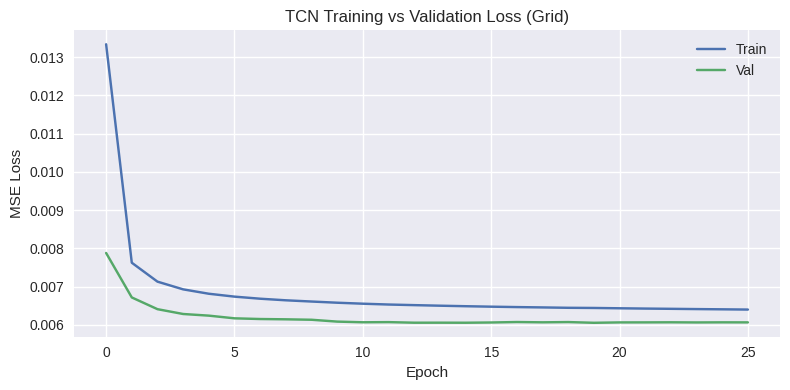

In [57]:
# TCN TRAINING

early_tcn = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_tcn = tcn_model_grid.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_tcn],
    verbose=1
)

tcn_grid_train_time = time.time() - start
print(f"\nTNC training time: {tcn_grid_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history_tcn.history['loss'], label='Train')
plt.plot(history_tcn.history['val_loss'], label='Val')
plt.title('TCN Training vs Validation Loss (Grid)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "tcn_grid.png"), dpi=150)
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
TCN RMSE: 0.7692965220142335
TCN MAE : 0.6598415535699721
TCN MAPE : 11.216786681859768
TCN R2 SCORE: 0.7276226579536613

TNC testing time: 0.85 seconds



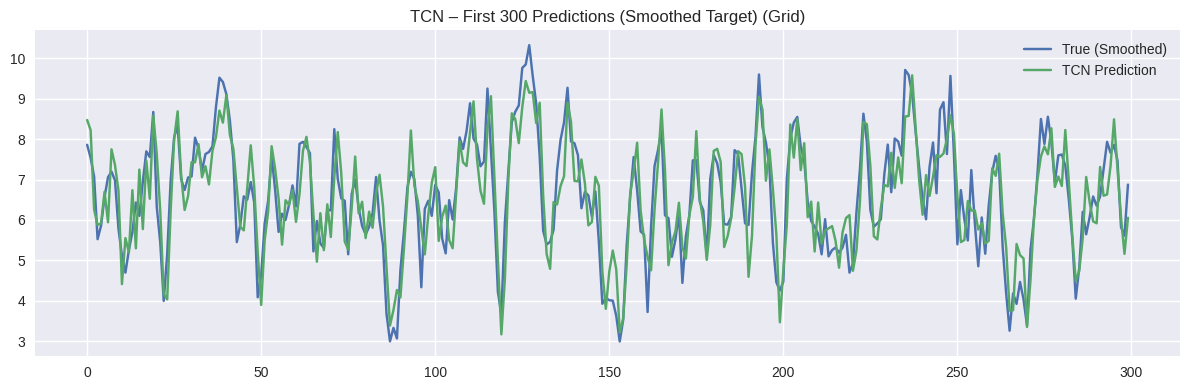

In [58]:
# TCN PREDICTION + INVERSE TRANSFORM

start = time.time() # start time

y_pred_tcn_scaled = tcn_model.predict(X_test_dl)

tcn_grid_test_time = time.time() - start

# Target column index for reverse scaling
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Rebuild a full scaled feature vector with the prediction inserted
    so MinMaxScaler.inverse_transform() works correctly.
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]


# Build inverse-transformed predictions
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]

    pred_val = invert_target(
        x_last, y_pred_tcn_scaled[i],
        scaler, target_idx
    )
    true_val = invert_target(
        x_last, y_test_dl[i],
        scaler, target_idx
    )

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#Metrics
mse_tcn_grid = mean_squared_error(y_true, y_pred)
rmse_tcn_grid = np.sqrt(mse_tcn)
mae_tcn_grid = mean_absolute_error(y_true, y_pred)
mape_tcn_grid = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_tcn_grid = r2_score(y_true, y_pred)

print("TCN RMSE:", rmse_tcn_grid)
print("TCN MAE :", mae_tcn_grid)
print("TCN MAPE :", mape_tcn_grid)
print("TCN R2 SCORE:", r2_tcn_grid)
print(f"\nTNC testing time: {tcn_grid_test_time:.2f} seconds\n")

# First 300 predictions plot
plt.figure(figsize=(12,4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='TCN Prediction')
plt.title("TCN – First 300 Predictions (Smoothed Target) (Grid)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "tcn_grid_predict.png"), dpi=150)
plt.show()


## 15.4 Transformer Grid-Search

In [ ]:
# Use Grid-Search for Transformer
best_tr_params, best_tr_rmse = tune_keras_model(
    lambda **p: build_transformer(WINDOW, n_features, **p),
    X_train_dl, y_train_dl,
    X_val_dl, y_val_dl,
    param_grid={
        "d_model": [64, 128],
        "num_heads": [2, 4, 8],
        "ff_dim": [128, 256],
        "dropout_rate": [0.1, 0.2],
        "lr": [1e-3, 3e-4],
    }
)

In [53]:
#Best Transformer via Grid-Search
transformer_model_grid = build_transformer(WINDOW, n_features, 128, 8, 128, 0.1, 1e-3)
transformer_model_grid.summary()
save_model_summary(transformer_model_grid, "transformer_grid_summary.txt")

Model: "Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 8, 9)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 8, 128)    │      1,280 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 128)    │     66,048 │ dense_13[0][0],   │
│ (MultiHeadAttentio… │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 8, 128)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 8, 128)    │          0 │ dense_13[0][0],   │
│                     │                   │            │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 128)    │        256 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 8, 128)    │     16,512 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 8, 128)    │          0 │ dense_14[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 8, 128)    │     16,512 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 8, 128)    │          0 │ dense_15[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 8, 128)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 8, 128)    │        256 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 32)        │      4,128 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         33 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,025 (410.25 KB)

 Trainable params: 105,025 (410.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 31s 24ms/step - loss: 0.0516 - val_loss: 0.0175
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0186 - val_loss: 0.0175
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.0177 - val_loss: 0.0155
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.0136 - val_loss: 0.0124
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - loss: 0.0125 - val_loss: 0.0119
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0121 - val_loss: 0.0122
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0119 - val_loss: 0.0118
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - loss: 0.0118 - val_loss: 0.0127
Epoch 10/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 27s 24ms/step - loss: 0.0117 - val_loss: 0.0125
Epoch 11/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - loss: 0.0116 - val_loss: 0.0122
Epoch 12

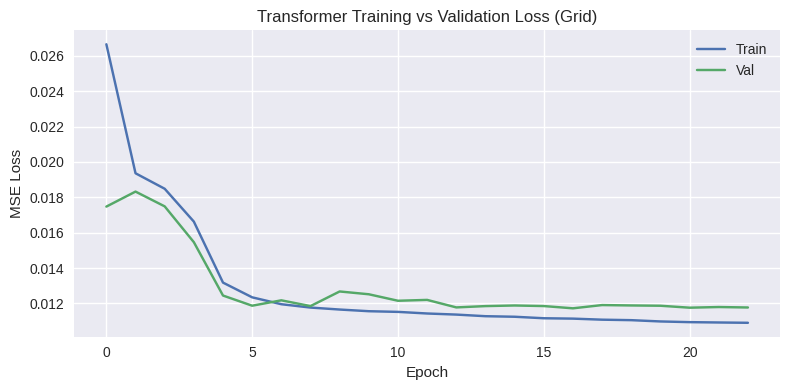

In [54]:
# TRANSFORMER TRAINING

early_transformer = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

start = time.time() # start time

history_transformer = transformer_model_grid.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_transformer],
    verbose=1
)

tr_grid_train_time = time.time() - start
print(f"\nTransformer training time: {tr_grid_train_time:.2f} seconds")

# Plot training vs validation loss
plt.figure(figsize=(8, 4))
plt.plot(history_transformer.history['loss'], label='Train')
plt.plot(history_transformer.history['val_loss'], label='Val')
plt.title('Transformer Training vs Validation Loss (Grid)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "transformer_grid.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Transformer RMSE: 1.029405498970337
Transformer MAE : 0.8498132717924315
Transformer MAPE: 14.103127677098193
Transformer R2 SCORE: 0.4924885086440227

Transformer testing time: 2.97 seconds



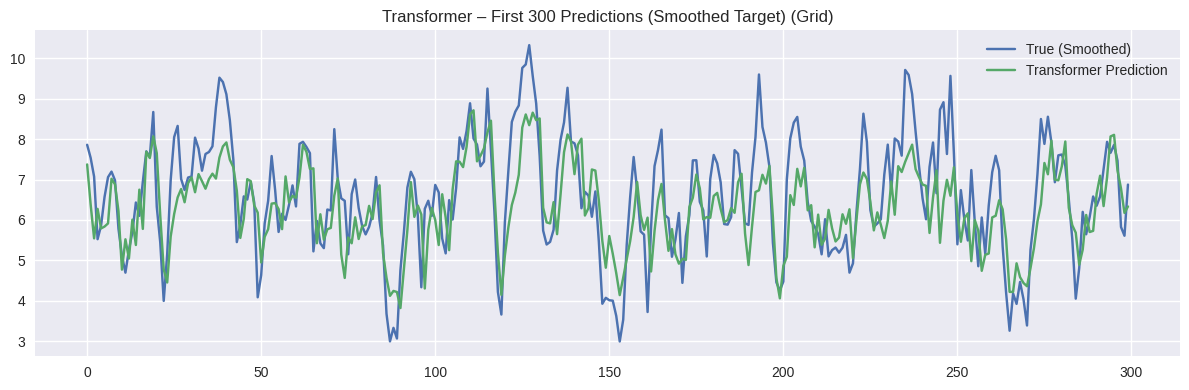

In [55]:
# TRANSFORMER EVALUATION


start = time.time() # start time

y_pred_transformer_scaled = transformer_model_grid.predict(X_test_dl)

tr_grid_test_time = time.time() - start

#target_idx and invert_target defined again to run cell independently
target_idx = list(df_feat.columns).index(target_col)

def invert_target(x_window_last, y_scaled_value, scaler, target_index):
    """
    Rebuilds a full row with scaled y inserted so MinMaxScaler
    can invert properly.
    """
    temp = x_window_last.copy()
    full_row = np.insert(temp, target_index, y_scaled_value)
    inv = scaler.inverse_transform([full_row])[0]
    return inv[target_index]


# Build inverse-transformed results
y_pred = []
y_true = []

for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]     # last timestep of window

    pred_val = invert_target(
        x_last,
        y_pred_transformer_scaled[i],
        scaler,
        target_idx
    )

    true_val = invert_target(
        x_last,
        y_test_dl[i],
        scaler,
        target_idx
    )

    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Metrics
mse_tr_grid = mean_squared_error(y_true, y_pred)
rmse_tr_grid = np.sqrt(mse_tr)
mae_tr_grid = mean_absolute_error(y_true, y_pred)
mape_tr_grid = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
r2_tr_grid = r2_score(y_true, y_pred)

print("Transformer RMSE:", rmse_tr_grid)
print("Transformer MAE :", mae_tr_grid)
print("Transformer MAPE:", mape_tr_grid)
print("Transformer R2 SCORE:", r2_tr_grid)
print(f"\nTransformer testing time: {tr_grid_test_time:.2f} seconds\n")

# Plot prediction window
plt.figure(figsize=(12, 4))
plt.plot(y_true[:300], label='True (Smoothed)')
plt.plot(y_pred[:300], label='Transformer Prediction')
plt.title("Transformer – First 300 Predictions (Smoothed Target) (Grid)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "transformer_grid_predict.png"), dpi=150)
plt.show()


## 15.5 RNN Grid-Search

In [ ]:
# Use Grid-Search for RNN
best_rnn_params, best_rnn_rmse = tune_keras_model(
    lambda **p: build_rnn(WINDOW, n_features, **p),
    X_train_dl, y_train_dl,
    X_val_dl, y_val_dl,
    param_grid={
        "units1": [32, 64],
        "units2": [16, 32],
        "dropout_rate": [0.1, 0.3],
        "lr": [1e-3, 3e-4],
    }
)

In [50]:
#Best RNN via Grid-Search
rnn_model_grid = build_rnn(WINDOW, n_features, 64, 32, 0.1, 1e-3)
rnn_model_grid.summary()
save_model_summary(rnn_model_grid, "rnn_grid_summary.txt")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 8, 64)          │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,873 (30.75 KB)

 Trainable params: 7,873 (30.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0748 - val_loss: 0.0067
Epoch 2/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0106 - val_loss: 0.0067
Epoch 3/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0082 - val_loss: 0.0063
Epoch 4/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 0.0074 - val_loss: 0.0070
Epoch 5/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 6/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0069 - val_loss: 0.0065
Epoch 7/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0067 - val_loss: 0.0069
Epoch 8/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 9/40
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0066 - val_loss: 0.0067

RNN training time: 75.25 seconds


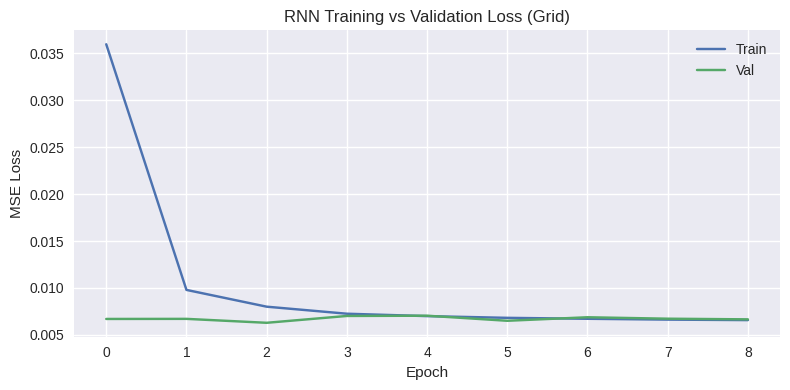

In [51]:
# RNN TRAINING

early_rnn = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=6, restore_best_weights=True
)

start = time.time() # start time

history_rnn = rnn_model_grid.fit(
    X_train_dl, y_train_dl,
    validation_data=(X_val_dl, y_val_dl),
    epochs=40,
    batch_size=32,
    callbacks=[early_rnn],
    verbose=1
)

rnn_grid_train_time = time.time() - start
print(f"\nRNN training time: {rnn_grid_train_time:.2f} seconds")

plt.figure(figsize=(8, 4))
plt.plot(history_rnn.history["loss"], label="Train")
plt.plot(history_rnn.history["val_loss"], label="Val")
plt.title("RNN Training vs Validation Loss (Grid)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "rnn_grid.png"), dpi=150)
plt.show()


235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RNN RMSE: 0.7695839429218196
RNN MAE : 0.6603497350969666
RNN MAPE : 11.006842735356633
RNN R2 SCORE: 0.7274190912788778

RNN testing time: 1.36 seconds



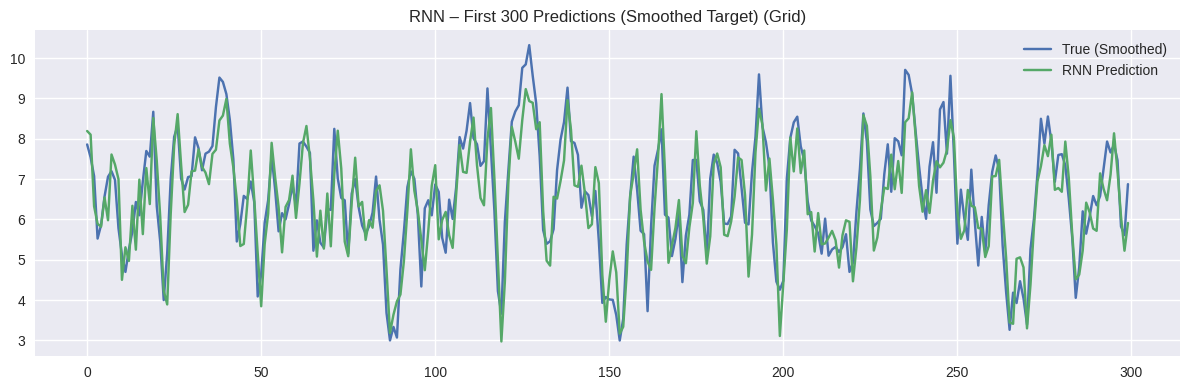

In [52]:
# RNN EVALUATION

start = time.time() # start time

y_pred_rnn_scaled = rnn_model_grid.predict(X_test_dl)

rnn_grid_test_time = time.time() - start

y_pred, y_true = [], []
for i in range(len(X_test_dl)):
    x_last = X_test_dl[i][-1]
    pred_val = invert_target(x_last, y_pred_rnn_scaled[i], scaler, target_idx)
    true_val = invert_target(x_last, y_test_dl[i],          scaler, target_idx)
    y_pred.append(pred_val)
    y_true.append(true_val)

y_pred = np.array(y_pred)
y_true = np.array(y_true)

#Metrics
mse_rnn_grid = mean_squared_error(y_true, y_pred)
rmse_rnn_grid = np.sqrt(mse_rnn_grid)
mae_rnn_grid = mean_absolute_error(y_true, y_pred)
mape_rnn_grid = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2_rnn_grid = r2_score(y_true, y_pred)

print("RNN RMSE:", rmse_rnn_grid)
print("RNN MAE :", mae_rnn_grid)
print("RNN MAPE :", mape_rnn_grid)
print("RNN R2 SCORE:", r2_rnn_grid)
print(f"\nRNN testing time: {rnn_grid_test_time:.2f} seconds\n")

# Plotting
plt.figure(figsize=(12, 4))
plt.plot(y_true[:300], label="True (Smoothed)")
plt.plot(y_pred[:300], label="RNN Prediction")
plt.title("RNN – First 300 Predictions (Smoothed Target) (Grid)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "rnn_predict_grid.png"), dpi=150)
plt.show()

# Section 16 Comparing Models

## 16.1 Comparing LSTM Models

In [59]:

results_lstm = []

results_lstm.append({
    "Model": "LSTM (base)",
    "RMSE": rmse_lstm,
    "MAE": mae_lstm,
    "MAPE (%)": mape_lstm,
    "R2": r2_lstm,
    "Train Time (s)": lstm_train_time,
    "Test Time (s)": lstm_test_time,
})

results_lstm.append({
    "Model": "LSTM (grid search)",
    "RMSE": rmse_lstm_grid,
    "MAE": mae_lstm_grid,
    "MAPE (%)": mape_lstm_grid,
    "R2": r2_lstm_grid,
    "Train Time (s)": lstm_grid_train_time,
    "Test Time (s)": lstm_grid_test_time,
})

results_lstm.append({
    "Model": "LSTM (Keras Tuner)",
    "RMSE": rmse_lstm_keras,
    "MAE": mae_lstm_keras,
    "MAPE (%)": mape_lstm_keras,
    "R2": r2_lstm_keras,
    "Train Time (s)": lstm_keras_train_time,
    "Test Time (s)": lstm_keras_test_time,
})

df_lstm_compare = pd.DataFrame(results_lstm)
df_lstm_compare = df_lstm_compare.sort_values("RMSE").reset_index(drop=True)

print(df_lstm_compare.round(4))
df_lstm_compare.to_csv(os.path.join(RESULTS_DIR, "lstm_comparison_table.csv"),
                  index=False)


                Model    RMSE     MAE  MAPE (%)      R2  Train Time (s)  \
0         LSTM (base)  0.7630  0.6565   10.9840  0.7321       1126.3021   
1  LSTM (Keras Tuner)  0.7630  0.6602   10.9929  0.7283       1173.1198   
2  LSTM (grid search)  0.7667  0.6597   11.0092  0.7295        915.0864   

   Test Time (s)  
0         2.9054  
1         3.1323  
2         2.0106  


## 16.2 Comparing GRU Models

In [60]:

results_gru = []

results_gru.append({
    "Model": "GRU (base)",
    "RMSE": rmse_gru,
    "MAE": mae_gru,
    "MAPE (%)": mape_gru,
    "R2": r2_gru,
    "Train Time (s)": gru_train_time,
    "Test Time (s)": gru_test_time,
})

results_gru.append({
    "Model": "GRU (grid search)",
    "RMSE": rmse_gru_grid,
    "MAE": mae_gru_grid,
    "MAPE (%)": mape_gru_grid,
    "R2": r2_gru_grid,
    "Train Time (s)": gru_grid_train_time,
    "Test Time (s)": gru_grid_test_time,
})

results_gru.append({
    "Model": "GRU (Keras Tuner)",
    "RMSE": rmse_gru_keras,
    "MAE": mae_gru_keras,
    "MAPE (%)": mape_gru_keras,
    "R2": r2_gru_keras,
    "Train Time (s)": gru_keras_train_time,
    "Test Time (s)": gru_keras_test_time,
})

df_gru_compare = pd.DataFrame(results_gru)
df_gru_compare = df_gru_compare.sort_values("RMSE").reset_index(drop=True)

print(df_gru_compare.round(4))
df_gru_compare.to_csv(os.path.join(RESULTS_DIR, "gru_comparison_table.csv"),
                  index=False)


               Model    RMSE     MAE  MAPE (%)      R2  Train Time (s)  \
0         GRU (base)  0.7571  0.6525   11.0176  0.7362        453.7464   
1  GRU (grid search)  0.7571  0.6537   10.9963  0.7346        745.7909   
2  GRU (Keras Tuner)  0.7571  0.6602   10.9794  0.7285        872.3991   

   Test Time (s)  
0         1.5653  
1         2.0269  
2         2.2485  


## 16.3 Comparing TCN Models

In [61]:

results_tcn = []

results_tcn.append({
    "Model": "TCN (base)",
    "RMSE": rmse_tcn,
    "MAE": mae_tcn,
    "MAPE (%)": mape_tcn,
    "R2": r2_tcn,
    "Train Time (s)": tcn_train_time,
    "Test Time (s)": tcn_test_time,
})

results_tcn.append({
    "Model": "TCN (grid search)",
    "RMSE": rmse_tcn_grid,
    "MAE": mae_tcn_grid,
    "MAPE (%)": mape_tcn_grid,
    "R2": r2_tcn_grid,
    "Train Time (s)": tcn_grid_train_time,
    "Test Time (s)": tcn_grid_test_time,
})

results_tcn.append({
    "Model": "TCN (Keras Tuner)",
    "RMSE": rmse_tcn_keras,
    "MAE": mae_tcn_keras,
    "MAPE (%)": mape_tcn_keras,
    "R2": r2_tcn_keras,
    "Train Time (s)": tcn_keras_train_time,
    "Test Time (s)": tcn_keras_test_time,
})

df_tcn_compare = pd.DataFrame(results_tcn)
df_tcn_compare = df_tcn_compare.sort_values("RMSE").reset_index(drop=True)

print(df_tcn_compare.round(4))
df_tcn_compare.to_csv(os.path.join(RESULTS_DIR, "tcn_comparison_table.csv"),
                  index=False)


               Model    RMSE     MAE  MAPE (%)      R2  Train Time (s)  \
0         TCN (base)  0.7693  0.6598   11.2168  0.7276        150.6161   
1  TCN (grid search)  0.7693  0.6598   11.2168  0.7276        133.1702   
2  TCN (Keras Tuner)  0.7693  0.6592   11.3100  0.7287         71.2050   

   Test Time (s)  
0         0.8428  
1         0.8546  
2         0.7960  


## 16.4 Comparing Transformer Models

In [62]:

results_tr = []

results_tr.append({
    "Model": "Transformer (base)",
    "RMSE": rmse_tr,
    "MAE": mae_tr,
    "MAPE (%)": mape_tr,
    "R2": r2_tr,
    "Train Time (s)": tr_train_time,
    "Test Time (s)": tr_test_time,
})

results_tr.append({
    "Model": "Transformer (grid search)",
    "RMSE": rmse_tr_grid,
    "MAE": mae_tr_grid,
    "MAPE (%)": mape_tr_grid,
    "R2": r2_tr_grid,
    "Train Time (s)": tr_grid_train_time,
    "Test Time (s)": tr_grid_test_time,
})

results_tr.append({
    "Model": "Transformer (Keras Tuner)",
    "RMSE": rmse_tr_keras,
    "MAE": mae_tr_keras,
    "MAPE (%)": mape_tr_keras,
    "R2": r2_tr_keras,
    "Train Time (s)": tr_keras_train_time,
    "Test Time (s)": tr_keras_test_time,
})

df_tr_compare = pd.DataFrame(results_tr)
df_tr_compare = df_tr_compare.sort_values("RMSE").reset_index(drop=True)

print(df_tr_compare.round(4))
df_tr_compare.to_csv(os.path.join(RESULTS_DIR, "tr_comparison_table.csv"),
                  index=False)


                       Model    RMSE     MAE  MAPE (%)      R2  \
0         Transformer (base)  1.0294  0.8337   13.9211  0.5123   
1  Transformer (grid search)  1.0294  0.8498   14.1031  0.4925   
2  Transformer (Keras Tuner)  1.0294  0.8337   13.9211  0.5123   

   Train Time (s)  Test Time (s)  
0        430.3800         1.3334  
1        701.3833         2.9671  
2       1165.2010         1.2700  


## 16.5 Comparing RNN Models

In [63]:

results_rnn = []

results_rnn.append({
    "Model": "RNN (base)",
    "RMSE": rmse_rnn,
    "MAE": mae_rnn,
    "MAPE (%)": mape_rnn,
    "R2": r2_rnn,
    "Train Time (s)": rnn_train_time,
    "Test Time (s)": rnn_test_time,
})

results_rnn.append({
    "Model": "RNN (grid search)",
    "RMSE": rmse_rnn_grid,
    "MAE": mae_rnn_grid,
    "MAPE (%)": mape_rnn_grid,
    "R2": r2_rnn_grid,
    "Train Time (s)": rnn_grid_train_time,
    "Test Time (s)": rnn_grid_test_time,
})

results_rnn.append({
    "Model": "RNN (Keras Tuner)",
    "RMSE": rmse_rnn_keras,
    "MAE": mae_rnn_keras,
    "MAPE (%)": mape_rnn_keras,
    "R2": r2_rnn_keras,
    "Train Time (s)": rnn_keras_train_time,
    "Test Time (s)": rnn_keras_test_time,
})

df_rnn_compare = pd.DataFrame(results_rnn)
df_rnn_compare = df_rnn_compare.sort_values("RMSE").reset_index(drop=True)

print(df_rnn_compare.round(4))
df_rnn_compare.to_csv(os.path.join(RESULTS_DIR, "rnn_comparison_table.csv"),
                  index=False)


               Model    RMSE     MAE  MAPE (%)      R2  Train Time (s)  \
0         RNN (base)  0.7634  0.6562   11.0722  0.7318        165.6636   
1  RNN (Keras Tuner)  0.7634  0.6539   11.0495  0.7345        181.5200   
2  RNN (grid search)  0.7696  0.6603   11.0068  0.7274         75.2486   

   Test Time (s)  
0         1.1346  
1         1.1039  
2         1.3601  


## 16.6 Comparing the Best of each Model

In [64]:

results = []

#Append Best of Each Model
results.append({
    "Model": "Naive (lag-1)",
    "RMSE": rmse_naive,
    "MAE": mae_naive,
    "MAPE (%)": mape_naive,
    "R2": r2_naive,
    "Train Time (s)": 0.0,
    "Test Time (s)": None
})

results.append({
    "Model": "LSTM",
    "RMSE": rmse_lstm,
    "MAE": mae_lstm,
    "MAPE (%)": mape_lstm,
    "R2": r2_lstm,
    "Train Time (s)": lstm_train_time,
    "Test Time (s)": lstm_test_time
})

results.append({
    "Model": "GRU",
    "RMSE": rmse_gru,
    "MAE": mae_gru,
    "MAPE (%)": mape_gru,
    "R2": r2_gru,
    "Train Time (s)": gru_train_time,
    "Test Time (s)": gru_test_time
})

results.append({
    "Model": "Transformer",
    "RMSE": rmse_tr,
    "MAE": mae_tr,
    "MAPE (%)": mape_tr,
    "R2": r2_tr,
    "Train Time (s)": tr_train_time,
    "Test Time (s)": tr_test_time
})

results.append({
    "Model": "TCN",
    "RMSE": rmse_tcn_keras,
    "MAE": mae_tcn_keras,
    "MAPE (%)": mape_tcn_keras,
    "R2": r2_tcn_keras,
    "Train Time (s)": tcn_keras_train_time,
    "Test Time (s)": tcn_keras_test_time
})

results.append({
    "Model": "RNN",
    "RMSE": rmse_rnn_keras,
    "MAE": mae_rnn_keras,
    "MAPE (%)": mape_rnn_keras,
    "R2": r2_rnn_keras,
    "Train Time (s)": rnn_keras_train_time,
    "Test Time (s)": rnn_keras_test_time
})

results.append({
    "Model": "ARIMA",
    "RMSE": rmse_arima,
    "MAE": mae_arima,
    "MAPE (%)": mape_arima,
    "R2": r2_arima,
    "Train Time (s)": arima_train_time,
    "Test Time (s)": arima_test_time
})

results.append({
    "Model": "SARIMA (hourly)",
    "RMSE": rmse_sarima,
    "MAE": mae_sarima,
    "MAPE (%)": mape_sarima,
    "R2": r2_sarima,
    "Train Time (s)": sarima_train_time,
    "Test Time (s)": sarima_test_time
})

# Create DataFrame
df_results = pd.DataFrame(results)

# Optional: sort by RMSE
df_results = df_results.sort_values("RMSE").reset_index(drop=True)

# Pretty print
print(df_results.round(4))

# Save for report
df_results.to_csv(os.path.join(RESULTS_DIR, "model_comparison_table.csv"),
                  index=False)


             Model    RMSE     MAE  MAPE (%)      R2  Train Time (s)  \
0    Naive (lag-1)  0.0000  0.0000    0.0000  1.0000          0.0000   
1              GRU  0.7571  0.6525   11.0176  0.7362        453.7464   
2             LSTM  0.7630  0.6565   10.9840  0.7321       1126.3021   
3              RNN  0.7634  0.6539   11.0495  0.7345        181.5200   
4              TCN  0.7693  0.6592   11.3100  0.7287         71.2050   
5      Transformer  1.0294  0.8337   13.9211  0.5123        430.3800   
6  SARIMA (hourly)  1.4834  1.1901   21.2753 -0.0059         90.5847   
7            ARIMA  2.9975  2.5946   67.3074 -0.0001         15.6522   

   Test Time (s)  
0            NaN  
1         1.5653  
2         2.9054  
3         1.1039  
4         0.7960  
5         1.3334  
6         0.2318  
7         0.3942  
